# This notebook does the 2-point and 3-point fits simultaneously

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [7]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-7-2f60309b0160>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-2f60309b0160>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-2f60309b0160>:17: RuntimeWarning: invalid value encount

In [8]:
np.shape(gv_avg_data['FH'])

(64, 4)

#### Define functions

In [9]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [10]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [11]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [12]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction uses

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0s
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [13]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [14]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -1: ## t_sel[1] == -1 is the condition for the A3 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][0]], [FHdata_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -2: ## t_sel[1] == -2 is the condition for the V4 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][2]], [FHdata_t_sel_res[0][3]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt_combined'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [15]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

<ipython-input-15-e0790b6350f7>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])


#### Do the fits

In [16]:
p=gv.BufferDict()
p['E0'] = gv.gvar(0.67, 0.02)
p['Z0'] = gv.gvar(0.0008, 0.0003)
p['Ztilde0'] = gv.gvar(0.003, 0.003)
dE0 = 2*mpi

num_zs = 7

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
#dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0008, 0.0004)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.005)

#print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)


In [17]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all

#print(np.shape(y_all_dict['3pt_combined']))


fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p

<ipython-input-17-e5f134a9ec8d>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-17-e5f134a9ec8d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.85 [150]    Q = 0.91    logGBF = 3791.3

Parameters:
             E0        0.659322 +- 0.0055261             [     0.67 +- 0.02 ]  
             Z0    0.000741361 +- 3.1676e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276539 +- 0.000135565             [   0.003 +- 0.003 ]  
       log(dE1)          -1.7466 +- 0.541143             [  -0.97551 +- 0.7 ]  *
             Z1     0.0002865 +- 0.000159498             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00180382 +- 0.000632948             [       0 +- 0.005 ]  
       log(dE2)         -1.15183 +- 0.396342             [  -0.97551 +- 0.7 ]  
             Z2    0.000552828 +- 0.00015541             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00319181 +- 0.00136881             [       0 +- 0.005 ]  
       log(dE3)        -0.880658 +- 0.376959             [  -0.97551 +- 0.7 ]  
             Z3    0.00077492 +- 0.000200149             [ 0.0008 +- 0.0004 ]  
        Ztilde3     0.0075

In [18]:
current_posterior = open('simul2pt3pt_n5_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

### Now, plot the data against the fit

In [19]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-19-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-19-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-19-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [20]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

#CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
#CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
#CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
#CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-20-01b164071101>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-20-01b164071101>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-20-01b164071101>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

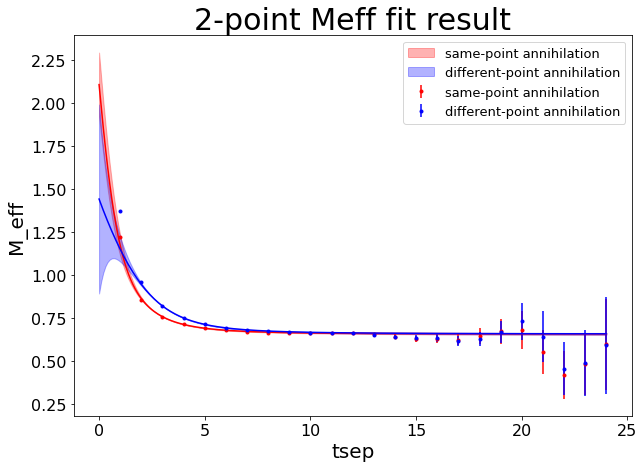

<Figure size 432x288 with 0 Axes>

In [21]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

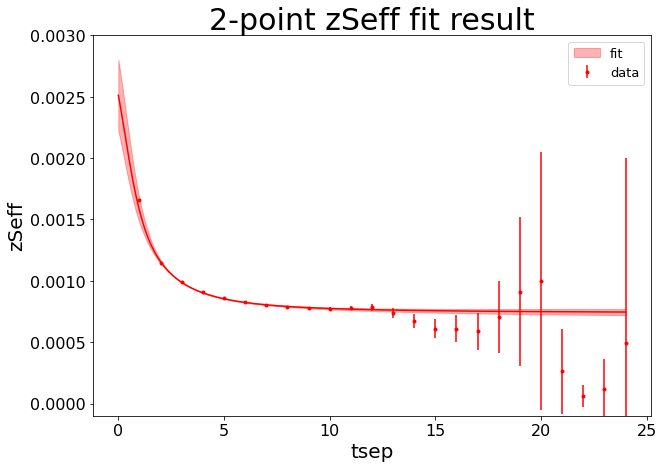

<Figure size 432x288 with 0 Axes>

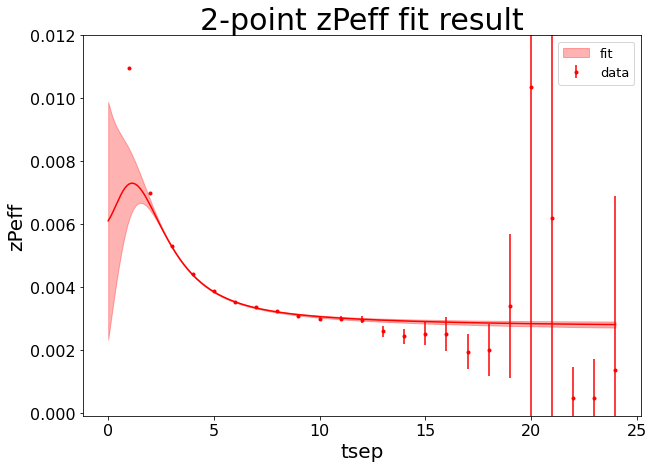

<Figure size 432x288 with 0 Axes>

In [22]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

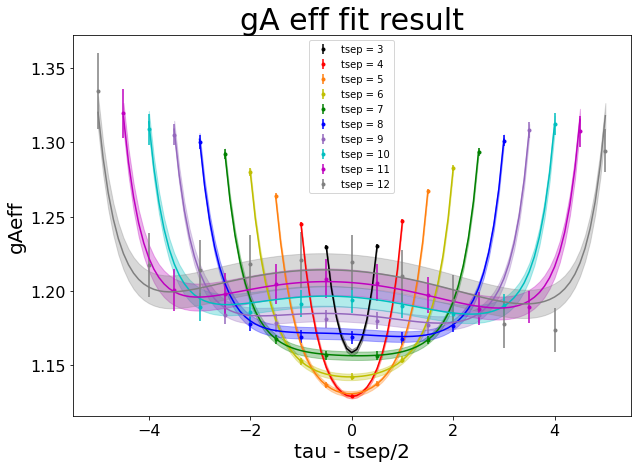

<Figure size 432x288 with 0 Axes>

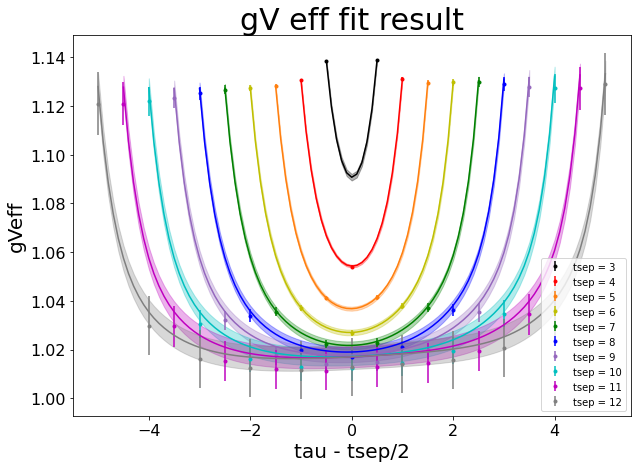

<Figure size 432x288 with 0 Axes>

In [23]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



#### Now, try the same, but with the 3-point data cut off at tau = 2

In [24]:
num_zs = 4
tau_cut_val = 2

x_2pt = np.array([l for l in range(3, 13)])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)


y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

x_all_tau2 = np.append(x_2pt_mod, x_1darray_tau2) 
y_all_tau2 = np.append(y_2pt_all, y_3pt_tau2)

x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-24-d3eebb14bf85>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-24-d3eebb14bf85>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.91 [110]    Q = 0.73    logGBF = 2804.9

Parameters:
             E0       0.653305 +- 0.00768896             [     0.67 +- 0.02 ]  
             Z0   0.000702274 +- 4.96356e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00260991 +- 0.000207349             [   0.003 +- 0.003 ]  
       log(dE1)         -1.87627 +- 0.377483             [  -0.97551 +- 0.7 ]  *
             Z1      0.0004305 +- 9.3257e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00205741 +- 0.00031863             [       0 +- 0.005 ]  
       log(dE2)          -0.84633 +- 0.23384             [  -0.97551 +- 0.7 ]  
             Z2     0.000470153 +- 0.0001328             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00454381 +- 0.0008303             [       0 +- 0.005 ]  
       log(dE3)        -0.884766 +- 0.289234             [  -0.97551 +- 0.7 ]  
             Z3     0.0010913 +- 6.91321e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde3    0.007056

In [25]:
current_posterior = open('simul2pt3pt_tau2_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [26]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-26-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-26-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-26-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [27]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-27-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-27-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-27-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

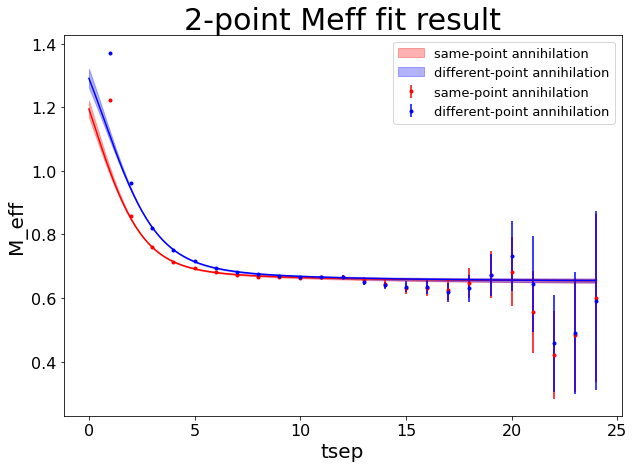

<Figure size 432x288 with 0 Axes>

In [28]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

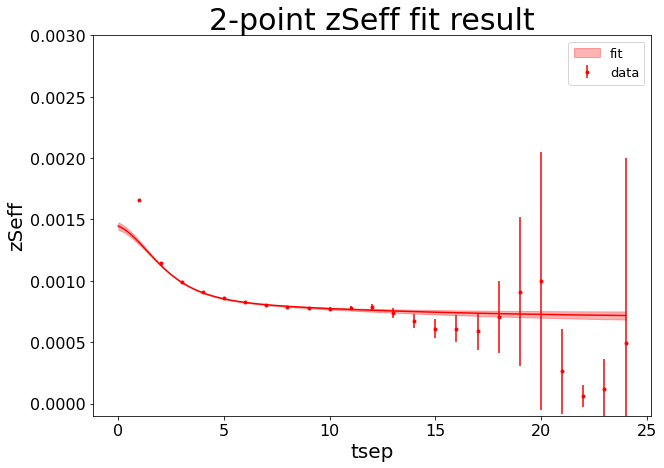

<Figure size 432x288 with 0 Axes>

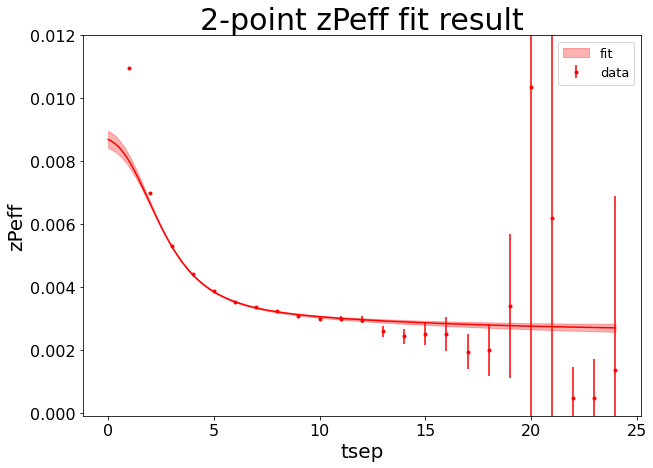

<Figure size 432x288 with 0 Axes>

In [29]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

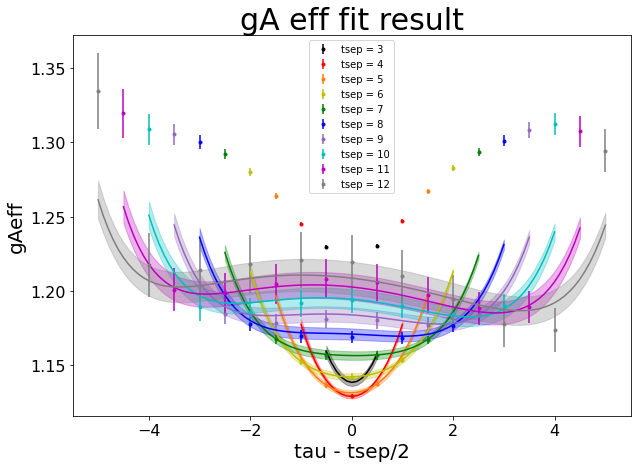

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

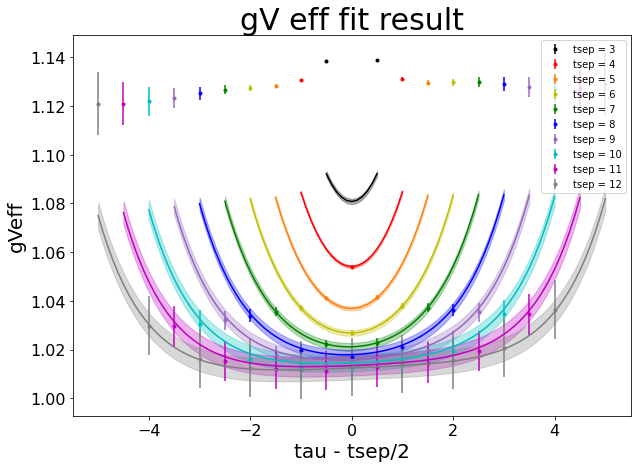

<Figure size 432x288 with 0 Axes>

In [30]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


### Now, include the fit to the Feynman-Hellman data in the chained fit

In [31]:
num_zs = 7
num_states_FH = 2

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0008, 0.0004)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.005)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior["d_gA_ss_{}".format(n)] = gv.gvar(-0.0000015, 0.0000015)
    prior["d_gA_ps_{}".format(n)] = gv.gvar(-0.000009, 0.000009)
    prior["d_gV_ss_{}".format(n)] = gv.gvar(0.0000013, 0.0000013)
    prior["d_gV_ps_{}".format(n)] = gv.gvar(0.0000075, 0.0000075)
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior['Ztilde_FHmax'] = gv.gvar(0, 0.005)
prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 1)
    prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 1)
    
prior['gA3_FHmaxFHmax'] = gv.gvar(0, 1)
prior['gV4_FHmaxFHmax'] = gv.gvar(1, 0.2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior

0


In [32]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p
# chi2/dof [dof] = 0.85 [186]    Q = 0.94    logGBF = 3892.8
# chi2/dof [dof] = 0.83 [186]    Q = 0.96    logGBF = 3868.1
# chi2/dof [dof] = 0.8 [186]    Q = 0.98    logGBF = 3879.4

<ipython-input-32-bdfe00743b5f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-32-bdfe00743b5f>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
/Users/ivan/miniconda3/lib/python3.8/site-packages/lsqfit/__init__.py:729: UserWarning: det(fit.cov) < 0 --- roundoff errors? Try an svd cut.
  warnin

Least Square Fit:
  chi2/dof [dof] = 1e+03 [186]    Q = 0    logGBF = -94790

Parameters:
             E0         0.670008 +- 0.0194689             [        0.67 +- 0.02 ]  
             Z0    9.83741e-06 +- 1.07733e-05             [    0.0008 +- 0.0003 ]  **
        Ztilde0      0.00270412 +- 0.00278396             [      0.003 +- 0.003 ]  
       log(dE1)           -0.97551 +- 0.14919             [     -0.97551 +- 0.7 ]  
             Z1    0.000272099 +- 4.53753e-05             [    0.0008 +- 0.0004 ]  *
        Ztilde1     0.00046606 +- 0.000314099             [          0 +- 0.005 ]  
       log(dE2)          -0.97551 +- 0.162546             [     -0.97551 +- 0.7 ]  
             Z2   -0.000211792 +- 9.44776e-05             [    0.0008 +- 0.0004 ]  **
        Ztilde2     0.000499839 +- 0.00154964             [          0 +- 0.005 ]  
       log(dE3)          -0.97551 +- 0.125216             [     -0.97551 +- 0.7 ]  
             Z3    8.05721e-05 +- 0.000340546             [    0.

In [33]:
current_posterior = open('simul2pt3pt_n5_withFH_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

#### Now, try the same, but with the 3-point data cut off at tau = 2

In [34]:
num_zs = 4
tau_cut_val = 3

# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt_all[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-34-21d9589bf2ff>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-34-21d9589bf2ff>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 1e+03 [186]    Q = 0    logGBF = -94790

Parameters:
             E0         0.670008 +- 0.0194689             [        0.67 +- 0.02 ]  
             Z0    9.83741e-06 +- 1.07733e-05             [    0.0008 +- 0.0003 ]  **
        Ztilde0      0.00270412 +- 0.00278396             [      0.003 +- 0.003 ]  
       log(dE1)           -0.97551 +- 0.14919             [     -0.97551 +- 0.7 ]  
             Z1    0.000272099 +- 4.53753e-05             [    0.0008 +- 0.0004 ]  *
        Ztilde1     0.00046606 +- 0.000314099             [          0 +- 0.005 ]  
       log(dE2)          -0.97551 +- 0.162546             [     -0.97551 +- 0.7 ]  
             Z2   -0.000211792 +- 9.44776e-05             [    0.0008 +- 0.0004 ]  **
        Ztilde2     0.000499839 +- 0.00154964             [          0 +- 0.005 ]  
       log(dE3)          -0.97551 +- 0.125216             [     -0.97551 +- 0.7 ]  
             Z3    8.05721e-05 +- 0.000340546             [    0.

Least Square Fit:
  chi2/dof [dof] = 0.84 [112]    Q = 0.9    logGBF = 2069.6

Parameters:
             E0         0.659527 +- 0.0032569             [        0.67 +- 0.02 ]  
             Z0    0.000748756 +- 1.36035e-05             [    0.0008 +- 0.0003 ]  
        Ztilde0     0.00282251 +- 5.87721e-05             [      0.003 +- 0.003 ]  
       log(dE1)          -1.00915 +- 0.161118             [     -0.97551 +- 0.7 ]  
             Z1     0.000560069 +- 7.5586e-05             [    0.0008 +- 0.0004 ]  
        Ztilde1     0.00347222 +- 0.000606517             [          0 +- 0.005 ]  
       log(dE2)         -0.597641 +- 0.215712             [     -0.97551 +- 0.7 ]  
             Z2    0.000780634 +- 0.000225226             [    0.0008 +- 0.0004 ]  
        Ztilde2       0.00738676 +- 0.0020038             [          0 +- 0.005 ]  *
       log(dE3)         -0.835404 +- 0.552982             [     -0.97551 +- 0.7 ]  
             Z3     0.00101314 +- 0.000218014             [    0.000

In [35]:
current_posterior = open('simul2pt3pt_tau2_withFH_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [36]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-36-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-36-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-36-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [37]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-37-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-37-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-37-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

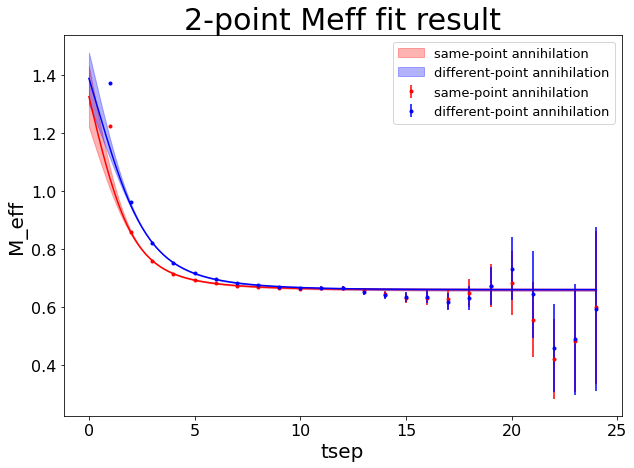

<Figure size 432x288 with 0 Axes>

In [38]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

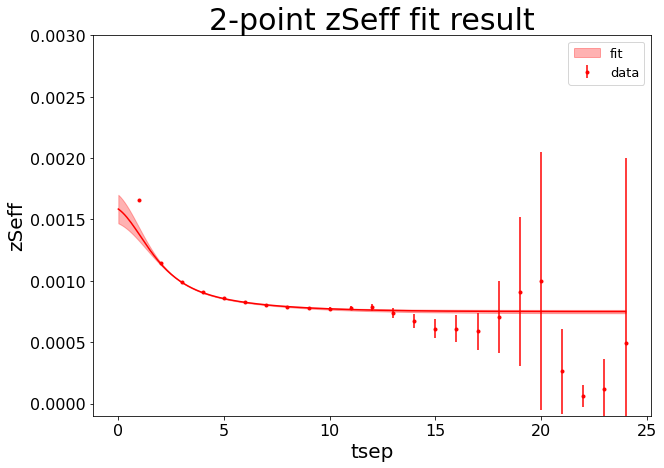

<Figure size 432x288 with 0 Axes>

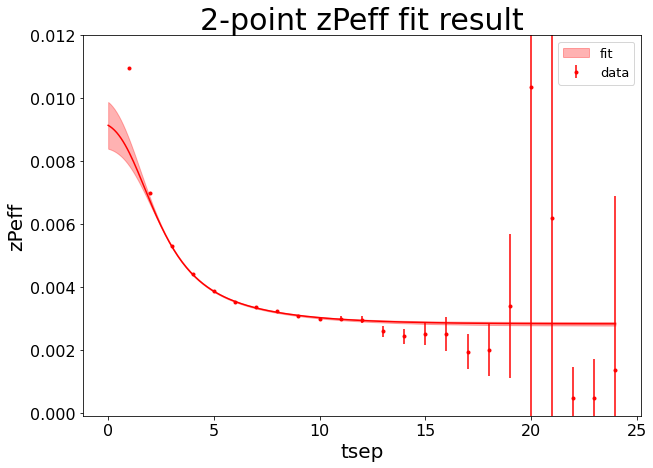

<Figure size 432x288 with 0 Axes>

In [39]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

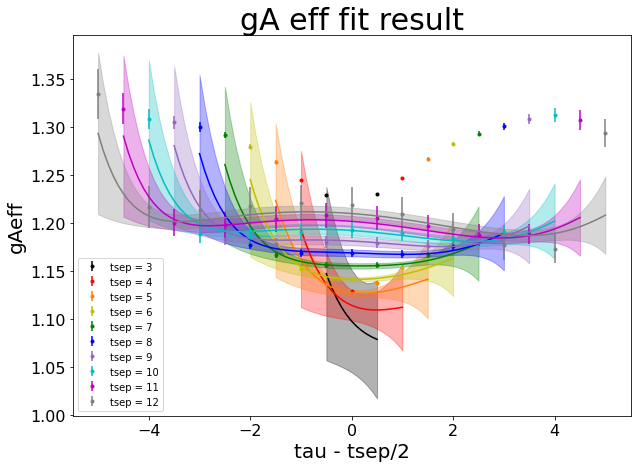

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

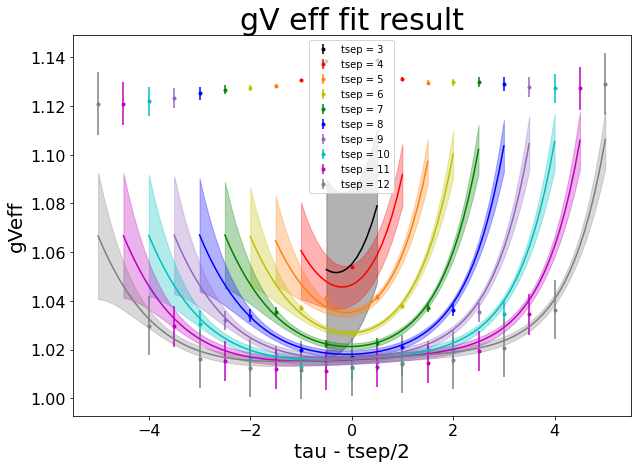

<Figure size 432x288 with 0 Axes>

In [40]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [41]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [42]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0008, 0.0004)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.005)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0008, 0.0004)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.005)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [43]:
list_LogGBF_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

In [44]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []
x_vals_all = []
y_vals_all = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    x_vals_all.append([])
    y_vals_all.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])
    
    x_vals_all[i] = np.append(x_2pt_mod, x_vals_3fit[i], axis = 0)
    y_vals_all[i] = np.append(y_2pt_all, y_vals_3fit[i], axis = 0)

<ipython-input-44-28236186c716>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-44-28236186c716>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Now that the priors and the data are set, do the fits

In [45]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[0][i][k],fcn=all_at_once,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[1][i][k],fcn=all_at_once,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[2][i][k],fcn=all_at_once,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0[i][j][k] = fit_a0.logGBF
            list_Q_a0[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv'))
            list_LogGBF_a1[i][j][k] = fit_a1.logGBF
            list_Q_a1[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2[i][j][k] = fit_a2.logGBF
            list_Q_a2[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2460.2

Parameters:
             E0      0.675628 +- 0.000981679             [     0.67 +- 0.02 ]  
             Z0   0.000798557 +- 2.36517e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00310892 +- 1.12241e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0681442 +- 0.00756341             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00123149 +- 1.01538e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1      0.00978943 +- 9.639e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.884457 +- 0.00800167             [  -0.97551 +- 0.7 ]  **
             Z2    0.00518257 +- 0.000312953             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0189562 +- 0.00485881             [       0 +- 0.005 ]  ***
         gA3_00        1.08707 +- 0.00180122             [     1.25 +- 0.15 ]  *
         gV4

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2460.2

Parameters:
             E0      0.675628 +- 0.000981679             [     0.67 +- 0.02 ]  
             Z0   0.000798557 +- 2.36517e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00310892 +- 1.12241e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0681442 +- 0.00756341             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00123149 +- 1.01538e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1      0.00978943 +- 9.639e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.884457 +- 0.00800167             [  -0.97551 +- 0.7 ]  **
             Z2    0.00518257 +- 0.000312953             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0189562 +- 0.00485881             [       0 +- 0.005 ]  ***
         gA3_00        1.08707 +- 0.00180122             [     1.25 +- 0.15 ]  *
         gV4

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 1.8e-24    logGBF = 3727.6

Parameters:
             E0        0.66274 +- 0.00196255             [     0.67 +- 0.02 ]  
             Z0    0.000761744 +- 6.6217e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028753 +- 2.91421e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.898821 +- 0.0491124             [  -0.97551 +- 0.1 ]  
             Z1   0.000552515 +- 3.07308e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00394716 +- 0.000171091             [       0 +- 0.005 ]  
       log(dE2)        -0.47201 +- 0.0522085             [  -0.97551 +- 0.7 ]  
             Z2    -0.00112611 +- 2.9011e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00794889 +- 0.000264466             [       0 +- 0.005 ]  *
       log(dE3)         1.25529 +- 0.0505658             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 1.8e-24    logGBF = 3727.6

Parameters:
             E0        0.66274 +- 0.00196255             [     0.67 +- 0.02 ]  
             Z0    0.000761744 +- 6.6217e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028753 +- 2.91421e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.898821 +- 0.0491124             [  -0.97551 +- 0.1 ]  
             Z1   0.000552515 +- 3.07308e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00394716 +- 0.000171091             [       0 +- 0.005 ]  
       log(dE2)        -0.47201 +- 0.0522085             [  -0.97551 +- 0.7 ]  
             Z2    -0.00112611 +- 2.9011e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00794889 +- 0.000264466             [       0 +- 0.005 ]  *
       log(dE3)         1.25529 +- 0.0505658             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51138

Parameters:
             E0         0.72978 +- 0.0148188             [     0.67 +- 0.02 ]  **
             Z0   0.000212347 +- 1.36171e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0      0.00108622 +- 8.294e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.909054 +- 0.0890005             [  -0.97551 +- 0.1 ]  
             Z1   0.000197558 +- 6.24861e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841537 +- 0.00303563             [       0 +- 0.005 ]  *
       log(dE2)        -0.905198 +- 0.506791             [  -0.97551 +- 0.7 ]  
             Z2   0.000117714 +- 0.000199737             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821035 +- 0.00496052             [       0 +- 0.005 ]  *
       log(dE3)        -0.892939 +- 0.483884             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51138

Parameters:
             E0         0.72978 +- 0.0148188             [     0.67 +- 0.02 ]  **
             Z0   0.000212347 +- 1.36171e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0      0.00108622 +- 8.294e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.909054 +- 0.0890005             [  -0.97551 +- 0.1 ]  
             Z1   0.000197558 +- 6.24861e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841537 +- 0.00303563             [       0 +- 0.005 ]  *
       log(dE2)        -0.905198 +- 0.506791             [  -0.97551 +- 0.7 ]  
             Z2   0.000117714 +- 0.000199737             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821035 +- 0.00496052             [       0 +- 0.005 ]  *
       log(dE3)        -0.892939 +- 0.483884             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3813.1

Parameters:
             E0        0.662213 +- 0.00278489             [     0.67 +- 0.02 ]  
             Z0    0.000759088 +- 1.05172e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286497 +- 4.46465e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.975694 +- 0.0829793             [  -0.97551 +- 0.1 ]  
             Z1    0.000517732 +- 7.10106e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1      0.00351275 +- 0.00035625             [       0 +- 0.005 ]  
       log(dE2)         -0.580382 +- 0.146281             [  -0.97551 +- 0.7 ]  
             Z2    0.000982218 +- 9.11738e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734609 +- 0.00125308             [       0 +- 0.005 ]  *
       log(dE3)           -1.03168 +- 0.54675             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3813.1

Parameters:
             E0        0.662213 +- 0.00278489             [     0.67 +- 0.02 ]  
             Z0    0.000759088 +- 1.05172e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286497 +- 4.46465e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.975694 +- 0.0829793             [  -0.97551 +- 0.1 ]  
             Z1    0.000517732 +- 7.10106e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1      0.00351275 +- 0.00035625             [       0 +- 0.005 ]  
       log(dE2)         -0.580382 +- 0.146281             [  -0.97551 +- 0.7 ]  
             Z2    0.000982218 +- 9.11738e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734609 +- 0.00125308             [       0 +- 0.005 ]  *
       log(dE3)           -1.03168 +- 0.54675             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.88    logGBF = 3807.5

Parameters:
             E0       0.662443 +- 0.00302669             [     0.67 +- 0.02 ]  
             Z0   0.000760491 +- 1.19818e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286718 +- 4.88903e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01447 +- 0.0935102             [  -0.97551 +- 0.1 ]  
             Z1   0.000434066 +- 0.000137189             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00337672 +- 0.000652535             [       0 +- 0.005 ]  
       log(dE2)         -1.36862 +- 0.501339             [  -0.97551 +- 0.7 ]  
             Z2   0.000539954 +- 0.000209917             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00234707 +- 0.00232435             [       0 +- 0.005 ]  
       log(dE3)        -0.944684 +- 0.436872             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.88    logGBF = 3807.5

Parameters:
             E0       0.662443 +- 0.00302669             [     0.67 +- 0.02 ]  
             Z0   0.000760491 +- 1.19818e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286718 +- 4.88903e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01447 +- 0.0935102             [  -0.97551 +- 0.1 ]  
             Z1   0.000434066 +- 0.000137189             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00337672 +- 0.000652535             [       0 +- 0.005 ]  
       log(dE2)         -1.36862 +- 0.501339             [  -0.97551 +- 0.7 ]  
             Z2   0.000539954 +- 0.000209917             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00234707 +- 0.00232435             [       0 +- 0.005 ]  
       log(dE3)        -0.944684 +- 0.436872             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00022    logGBF = 2798

Parameters:
             E0       0.661335 +- 0.00204735             [     0.67 +- 0.02 ]  
             Z0   0.000756358 +- 7.03996e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285013 +- 3.15246e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.903682 +- 0.0512834             [  -0.97551 +- 0.1 ]  
             Z1   0.000597949 +- 2.37548e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00411489 +- 0.000165186             [       0 +- 0.005 ]  
       log(dE2)       -0.322525 +- 0.0346611             [  -0.97551 +- 0.7 ]  
             Z2    0.00119536 +- 3.08785e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00859585 +- 0.000279672             [       0 +- 0.005 ]  *
         gA3_00         1.25106 +- 0.0112012             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00022    logGBF = 2798

Parameters:
             E0       0.661335 +- 0.00204735             [     0.67 +- 0.02 ]  
             Z0   0.000756358 +- 7.03996e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285013 +- 3.15246e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.903682 +- 0.0512834             [  -0.97551 +- 0.1 ]  
             Z1   0.000597949 +- 2.37548e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00411489 +- 0.000165186             [       0 +- 0.005 ]  
       log(dE2)       -0.322525 +- 0.0346611             [  -0.97551 +- 0.7 ]  
             Z2    0.00119536 +- 3.08785e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00859585 +- 0.000279672             [       0 +- 0.005 ]  *
         gA3_00         1.25106 +- 0.0112012             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.49    logGBF = 2813.6

Parameters:
             E0       0.664058 +- 0.00292731             [     0.67 +- 0.02 ]  
             Z0    0.000767629 +- 1.1706e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00289313 +- 4.75531e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.103 +- 0.0924431             [  -0.97551 +- 0.1 ]  *
             Z1   0.000334236 +- 0.000126704             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00289183 +- 0.00066085             [       0 +- 0.005 ]  
       log(dE2)         -1.52431 +- 0.418745             [  -0.97551 +- 0.7 ]  
             Z2    0.00044053 +- 0.000158086             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00260767 +- 0.00119789             [       0 +- 0.005 ]  
       log(dE3)        -0.894283 +- 0.295282             [  -0.97551 +- 0.7 ]  
             Z3    0.00106

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.49    logGBF = 2813.6

Parameters:
             E0       0.664058 +- 0.00292731             [     0.67 +- 0.02 ]  
             Z0    0.000767629 +- 1.1706e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00289313 +- 4.75531e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.103 +- 0.0924431             [  -0.97551 +- 0.1 ]  *
             Z1   0.000334236 +- 0.000126704             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00289183 +- 0.00066085             [       0 +- 0.005 ]  
       log(dE2)         -1.52431 +- 0.418745             [  -0.97551 +- 0.7 ]  
             Z2    0.00044053 +- 0.000158086             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00260767 +- 0.00119789             [       0 +- 0.005 ]  
       log(dE3)        -0.894283 +- 0.295282             [  -0.97551 +- 0.7 ]  
             Z3    0.00106

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.97    logGBF = 2812.3

Parameters:
             E0         0.6609 +- 0.00321944             [     0.67 +- 0.02 ]  
             Z0   0.000754328 +- 1.27407e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028448 +- 5.29727e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02015 +- 0.0916989             [  -0.97551 +- 0.1 ]  
             Z1   0.000503901 +- 9.81028e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00326766 +- 0.000473379             [       0 +- 0.005 ]  
       log(dE2)         -0.927154 +- 0.35955             [  -0.97551 +- 0.7 ]  
             Z2     0.000662495 +- 0.0001987             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00499671 +- 0.00169449             [       0 +- 0.005 ]  
       log(dE3)        -0.749906 +- 0.472901             [  -0.97551 +- 0.7 ]  
             Z3    0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.97    logGBF = 2812.3

Parameters:
             E0         0.6609 +- 0.00321944             [     0.67 +- 0.02 ]  
             Z0   0.000754328 +- 1.27407e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028448 +- 5.29727e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02015 +- 0.0916989             [  -0.97551 +- 0.1 ]  
             Z1   0.000503901 +- 9.81028e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00326766 +- 0.000473379             [       0 +- 0.005 ]  
       log(dE2)         -0.927154 +- 0.35955             [  -0.97551 +- 0.7 ]  
             Z2     0.000662495 +- 0.0001987             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00499671 +- 0.00169449             [       0 +- 0.005 ]  
       log(dE3)        -0.749906 +- 0.472901             [  -0.97551 +- 0.7 ]  
             Z3    0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2810.5

Parameters:
             E0       0.660978 +- 0.00324304             [     0.67 +- 0.02 ]  
             Z0   0.000754887 +- 1.29066e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284609 +- 5.31462e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02304 +- 0.0926929             [  -0.97551 +- 0.1 ]  
             Z1     0.0004858 +- 0.000113604             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00325561 +- 0.000521127             [       0 +- 0.005 ]  
       log(dE2)          -1.11545 +- 0.45495             [  -0.97551 +- 0.7 ]  
             Z2   0.000594491 +- 0.000213014             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00379194 +- 0.00212907             [       0 +- 0.005 ]  
       log(dE3)        -0.848329 +- 0.495602             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2810.5

Parameters:
             E0       0.660978 +- 0.00324304             [     0.67 +- 0.02 ]  
             Z0   0.000754887 +- 1.29066e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284609 +- 5.31462e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02304 +- 0.0926929             [  -0.97551 +- 0.1 ]  
             Z1     0.0004858 +- 0.000113604             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00325561 +- 0.000521127             [       0 +- 0.005 ]  
       log(dE2)          -1.11545 +- 0.45495             [  -0.97551 +- 0.7 ]  
             Z2   0.000594491 +- 0.000213014             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00379194 +- 0.00212907             [       0 +- 0.005 ]  
       log(dE3)        -0.848329 +- 0.495602             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2809.3

Parameters:
             E0       0.660994 +- 0.00324446             [     0.67 +- 0.02 ]  
             Z0   0.000755082 +- 1.29392e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284575 +- 5.30025e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02667 +- 0.0929792             [  -0.97551 +- 0.1 ]  
             Z1   0.000473396 +- 0.000122862             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00328062 +- 0.000555024             [       0 +- 0.005 ]  
       log(dE2)         -1.23371 +- 0.499744             [  -0.97551 +- 0.7 ]  
             Z2   0.000562098 +- 0.000216814             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00306651 +- 0.00237418             [       0 +- 0.005 ]  
       log(dE3)        -0.911262 +- 0.498701             [  -0.97551 +- 0.7 ]  
             Z3   0.00073

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2809.3

Parameters:
             E0       0.660994 +- 0.00324446             [     0.67 +- 0.02 ]  
             Z0   0.000755082 +- 1.29392e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284575 +- 5.30025e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.02667 +- 0.0929792             [  -0.97551 +- 0.1 ]  
             Z1   0.000473396 +- 0.000122862             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00328062 +- 0.000555024             [       0 +- 0.005 ]  
       log(dE2)         -1.23371 +- 0.499744             [  -0.97551 +- 0.7 ]  
             Z2   0.000562098 +- 0.000216814             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00306651 +- 0.00237418             [       0 +- 0.005 ]  
       log(dE3)        -0.911262 +- 0.498701             [  -0.97551 +- 0.7 ]  
             Z3   0.00073

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.2 [76]    Q = 0.17    logGBF = 1917.6

Parameters:
             E0       0.659785 +- 0.00225463             [     0.67 +- 0.02 ]  
             Z0   0.000751091 +- 7.73342e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00283117 +- 3.46451e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.850453 +- 0.0582874             [  -0.97551 +- 0.1 ]  *
             Z1    0.00066437 +- 3.45378e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00444235 +- 0.000245877             [       0 +- 0.005 ]  
       log(dE2)       -0.195039 +- 0.0802947             [  -0.97551 +- 0.7 ]  *
             Z2    0.00124956 +- 6.54916e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00927643 +- 0.000611226             [       0 +- 0.005 ]  *
         gA3_00         1.22201 +- 0.0137463             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [76]    Q = 0.17    logGBF = 1917.6

Parameters:
             E0       0.659785 +- 0.00225463             [     0.67 +- 0.02 ]  
             Z0   0.000751091 +- 7.73342e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00283117 +- 3.46451e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.850453 +- 0.0582874             [  -0.97551 +- 0.1 ]  *
             Z1    0.00066437 +- 3.45378e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00444235 +- 0.000245877             [       0 +- 0.005 ]  
       log(dE2)       -0.195039 +- 0.0802947             [  -0.97551 +- 0.7 ]  *
             Z2    0.00124956 +- 6.54916e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00927643 +- 0.000611226             [       0 +- 0.005 ]  *
         gA3_00         1.22201 +- 0.0137463             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1924.4

Parameters:
             E0       0.659283 +- 0.00307247             [     0.67 +- 0.02 ]  
             Z0   0.000747795 +- 1.18009e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281846 +- 4.98821e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00219 +- 0.0887154             [  -0.97551 +- 0.1 ]  
             Z1    0.000570724 +- 6.2634e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00353571 +- 0.000367715             [       0 +- 0.005 ]  
       log(dE2)        -0.562876 +- 0.204718             [  -0.97551 +- 0.7 ]  
             Z2   0.000797608 +- 0.000220344             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00752552 +- 0.00202582             [       0 +- 0.005 ]  *
       log(dE3)        -0.850135 +- 0.561617             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1924.4

Parameters:
             E0       0.659283 +- 0.00307247             [     0.67 +- 0.02 ]  
             Z0   0.000747795 +- 1.18009e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281846 +- 4.98821e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00219 +- 0.0887154             [  -0.97551 +- 0.1 ]  
             Z1    0.000570724 +- 6.2634e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00353571 +- 0.000367715             [       0 +- 0.005 ]  
       log(dE2)        -0.562876 +- 0.204718             [  -0.97551 +- 0.7 ]  
             Z2   0.000797608 +- 0.000220344             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00752552 +- 0.00202582             [       0 +- 0.005 ]  *
       log(dE3)        -0.850135 +- 0.561617             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1924.1

Parameters:
             E0       0.659019 +- 0.00309519             [     0.67 +- 0.02 ]  
             Z0   0.000746734 +- 1.19147e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00281451 +- 5.0303e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00185 +- 0.0893918             [  -0.97551 +- 0.1 ]  
             Z1   0.000575563 +- 6.38734e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00353666 +- 0.00037964             [       0 +- 0.005 ]  
       log(dE2)         -0.60444 +- 0.236217             [  -0.97551 +- 0.7 ]  
             Z2      0.000741959 +- 0.000239             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00693276 +- 0.00221107             [       0 +- 0.005 ]  *
       log(dE3)        -0.988684 +- 0.620158             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1924.1

Parameters:
             E0       0.659019 +- 0.00309519             [     0.67 +- 0.02 ]  
             Z0   0.000746734 +- 1.19147e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00281451 +- 5.0303e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00185 +- 0.0893918             [  -0.97551 +- 0.1 ]  
             Z1   0.000575563 +- 6.38734e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00353666 +- 0.00037964             [       0 +- 0.005 ]  
       log(dE2)         -0.60444 +- 0.236217             [  -0.97551 +- 0.7 ]  
             Z2      0.000741959 +- 0.000239             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00693276 +- 0.00221107             [       0 +- 0.005 ]  *
       log(dE3)        -0.988684 +- 0.620158             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1923.9

Parameters:
             E0       0.658882 +- 0.00311288             [     0.67 +- 0.02 ]  
             Z0   0.000746207 +- 1.20011e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281246 +- 5.05968e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00172 +- 0.0896462             [  -0.97551 +- 0.1 ]  
             Z1    0.000577373 +- 6.5152e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00353876 +- 0.000385263             [       0 +- 0.005 ]  
       log(dE2)        -0.633687 +- 0.256393             [  -0.97551 +- 0.7 ]  
             Z2   0.000711776 +- 0.000242914             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00648248 +- 0.00236098             [       0 +- 0.005 ]  *
       log(dE3)         -1.03589 +- 0.628283             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1923.9

Parameters:
             E0       0.658882 +- 0.00311288             [     0.67 +- 0.02 ]  
             Z0   0.000746207 +- 1.20011e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281246 +- 5.05968e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00172 +- 0.0896462             [  -0.97551 +- 0.1 ]  
             Z1    0.000577373 +- 6.5152e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00353876 +- 0.000385263             [       0 +- 0.005 ]  
       log(dE2)        -0.633687 +- 0.256393             [  -0.97551 +- 0.7 ]  
             Z2   0.000711776 +- 0.000242914             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00648248 +- 0.00236098             [       0 +- 0.005 ]  *
       log(dE3)         -1.03589 +- 0.628283             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1923.8

Parameters:
             E0        0.658822 +- 0.0031213             [     0.67 +- 0.02 ]  
             Z0   0.000745981 +- 1.20396e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281154 +- 5.07275e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.0015 +- 0.0896686             [  -0.97551 +- 0.1 ]  
             Z1    0.00057815 +- 6.57451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1      0.003542 +- 0.000386663             [       0 +- 0.005 ]  
       log(dE2)        -0.644898 +- 0.264212             [  -0.97551 +- 0.7 ]  
             Z2   0.000702835 +- 0.000242107             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00628991 +- 0.00242433             [       0 +- 0.005 ]  *
       log(dE3)         -1.04338 +- 0.627287             [  -0.97551 +- 0.7 ]  
             Z3   0.00076

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1923.8

Parameters:
             E0        0.658822 +- 0.0031213             [     0.67 +- 0.02 ]  
             Z0   0.000745981 +- 1.20396e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281154 +- 5.07275e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.0015 +- 0.0896686             [  -0.97551 +- 0.1 ]  
             Z1    0.00057815 +- 6.57451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1      0.003542 +- 0.000386663             [       0 +- 0.005 ]  
       log(dE2)        -0.644898 +- 0.264212             [  -0.97551 +- 0.7 ]  
             Z2   0.000702835 +- 0.000242107             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00628991 +- 0.00242433             [       0 +- 0.005 ]  *
       log(dE3)         -1.04338 +- 0.627287             [  -0.97551 +- 0.7 ]  
             Z3   0.00076

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2495.9

Parameters:
             E0        0.675674 +- 0.0009802             [     0.67 +- 0.02 ]  
             Z0   0.000798779 +- 2.36016e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311027 +- 1.12037e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0643224 +- 0.00753927             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00123543 +- 1.02046e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982257 +- 9.64641e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888082 +- 0.00816234             [  -0.97551 +- 0.7 ]  **
             Z2    0.00523583 +- 0.000314018             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187846 +- 0.00486568             [       0 +- 0.005 ]  ***
         gA3_00         1.0868 +- 0.00179704             [     1.25 +- 0.15 ]  *
         gV4_0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2495.9

Parameters:
             E0        0.675674 +- 0.0009802             [     0.67 +- 0.02 ]  
             Z0   0.000798779 +- 2.36016e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311027 +- 1.12037e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0643224 +- 0.00753927             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00123543 +- 1.02046e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982257 +- 9.64641e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888082 +- 0.00816234             [  -0.97551 +- 0.7 ]  **
             Z2    0.00523583 +- 0.000314018             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187846 +- 0.00486568             [       0 +- 0.005 ]  ***
         gA3_00         1.0868 +- 0.00179704             [     1.25 +- 0.15 ]  *
         gV4_0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.2e-24    logGBF = 3727.4

Parameters:
             E0       0.662938 +- 0.00194619             [     0.67 +- 0.02 ]  
             Z0    0.00076285 +- 6.58376e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00288154 +- 2.9289e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876307 +- 0.0551437             [  -0.97551 +- 0.3 ]  
             Z1   0.000557445 +- 3.20194e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00401503 +- 0.000196348             [       0 +- 0.005 ]  
       log(dE2)         -0.4908 +- 0.0578799             [  -0.97551 +- 0.7 ]  
             Z2    -0.0011182 +- 3.09902e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2     -0.00785219 +- 0.0002919             [       0 +- 0.005 ]  *
       log(dE3)          1.25613 +- 0.050772             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.2e-24    logGBF = 3727.4

Parameters:
             E0       0.662938 +- 0.00194619             [     0.67 +- 0.02 ]  
             Z0    0.00076285 +- 6.58376e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00288154 +- 2.9289e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876307 +- 0.0551437             [  -0.97551 +- 0.3 ]  
             Z1   0.000557445 +- 3.20194e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00401503 +- 0.000196348             [       0 +- 0.005 ]  
       log(dE2)         -0.4908 +- 0.0578799             [  -0.97551 +- 0.7 ]  
             Z2    -0.0011182 +- 3.09902e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2     -0.00785219 +- 0.0002919             [       0 +- 0.005 ]  *
       log(dE3)          1.25613 +- 0.050772             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51138

Parameters:
             E0        0.729778 +- 0.0153582             [     0.67 +- 0.02 ]  **
             Z0    0.000212352 +- 1.3898e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000103347             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909012 +- 0.163607             [  -0.97551 +- 0.3 ]  
             Z1    0.00019756 +- 7.50938e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     -0.00841559 +- 0.0031259             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506833             [  -0.97551 +- 0.7 ]  
             Z2    0.00011771 +- 0.000233209             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     -0.00821041 +- 0.0049671             [       0 +- 0.005 ]  *
       log(dE3)         -0.892942 +- 0.49993             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51138

Parameters:
             E0        0.729778 +- 0.0153582             [     0.67 +- 0.02 ]  **
             Z0    0.000212352 +- 1.3898e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000103347             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909012 +- 0.163607             [  -0.97551 +- 0.3 ]  
             Z1    0.00019756 +- 7.50938e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     -0.00841559 +- 0.0031259             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506833             [  -0.97551 +- 0.7 ]  
             Z2    0.00011771 +- 0.000233209             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     -0.00821041 +- 0.0049671             [       0 +- 0.005 ]  *
       log(dE3)         -0.892942 +- 0.49993             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3812.4

Parameters:
             E0        0.662211 +- 0.00284698             [     0.67 +- 0.02 ]  
             Z0    0.000759077 +- 1.10586e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286492 +- 4.81848e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.975975 +- 0.133279             [  -0.97551 +- 0.3 ]  
             Z1    0.000517636 +- 8.09264e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351175 +- 0.000521153             [       0 +- 0.005 ]  
       log(dE2)         -0.580312 +- 0.148251             [  -0.97551 +- 0.7 ]  
             Z2    0.000982255 +- 9.39055e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2        0.00734698 +- 0.001312             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.553573             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3812.4

Parameters:
             E0        0.662211 +- 0.00284698             [     0.67 +- 0.02 ]  
             Z0    0.000759077 +- 1.10586e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286492 +- 4.81848e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.975975 +- 0.133279             [  -0.97551 +- 0.3 ]  
             Z1    0.000517636 +- 8.09264e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351175 +- 0.000521153             [       0 +- 0.005 ]  
       log(dE2)         -0.580312 +- 0.148251             [  -0.97551 +- 0.7 ]  
             Z2    0.000982255 +- 9.39055e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2        0.00734698 +- 0.001312             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.553573             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.86 [150]    Q = 0.89    logGBF = 3800.9

Parameters:
             E0       0.661637 +- 0.00369905             [     0.67 +- 0.02 ]  
             Z0   0.000756149 +- 1.63247e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284204 +- 6.80516e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.22749 +- 0.244023             [  -0.97551 +- 0.3 ]  
             Z1     0.0003449 +- 0.000164299             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00264909 +- 0.000905361             [       0 +- 0.005 ]  
       log(dE2)         -1.35264 +- 0.472804             [  -0.97551 +- 0.7 ]  
             Z2   0.000554043 +- 0.000184808             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00273369 +- 0.00196366             [       0 +- 0.005 ]  
       log(dE3)        -0.912127 +- 0.407912             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.86 [150]    Q = 0.89    logGBF = 3800.9

Parameters:
             E0       0.661637 +- 0.00369905             [     0.67 +- 0.02 ]  
             Z0   0.000756149 +- 1.63247e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284204 +- 6.80516e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.22749 +- 0.244023             [  -0.97551 +- 0.3 ]  
             Z1     0.0003449 +- 0.000164299             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00264909 +- 0.000905361             [       0 +- 0.005 ]  
       log(dE2)         -1.35264 +- 0.472804             [  -0.97551 +- 0.7 ]  
             Z2   0.000554043 +- 0.000184808             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00273369 +- 0.00196366             [       0 +- 0.005 ]  
       log(dE3)        -0.912127 +- 0.407912             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00025    logGBF = 2797.6

Parameters:
             E0        0.66166 +- 0.00204752             [     0.67 +- 0.02 ]  
             Z0   0.000757996 +- 7.11057e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285879 +- 3.23038e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.879757 +- 0.0582896             [  -0.97551 +- 0.3 ]  
             Z1    0.00060292 +- 2.51255e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00418845 +- 0.000195378             [       0 +- 0.005 ]  
       log(dE2)       -0.338061 +- 0.0402773             [  -0.97551 +- 0.7 ]  
             Z2    0.00118702 +- 3.33497e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00848144 +- 0.00032098             [       0 +- 0.005 ]  *
         gA3_00         1.24711 +- 0.0117565             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00025    logGBF = 2797.6

Parameters:
             E0        0.66166 +- 0.00204752             [     0.67 +- 0.02 ]  
             Z0   0.000757996 +- 7.11057e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285879 +- 3.23038e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.879757 +- 0.0582896             [  -0.97551 +- 0.3 ]  
             Z1    0.00060292 +- 2.51255e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00418845 +- 0.000195378             [       0 +- 0.005 ]  
       log(dE2)       -0.338061 +- 0.0402773             [  -0.97551 +- 0.7 ]  
             Z2    0.00118702 +- 3.33497e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00848144 +- 0.00032098             [       0 +- 0.005 ]  *
         gA3_00         1.24711 +- 0.0117565             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.95 [110]    Q = 0.63    logGBF = 2807.6

Parameters:
             E0      0.660202 +- 0.00468339            [     0.67 +- 0.02 ]  
             Z0   0.000747126 +- 2.3075e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00280222 +- 9.50207e-05            [   0.003 +- 0.003 ]  
       log(dE1)        -1.48067 +- 0.235116            [  -0.97551 +- 0.3 ]  *
             Z1   0.00035492 +- 0.000107164            [ 0.0008 +- 0.0004 ]  *
        Ztilde1   0.00205928 +- 0.000448653            [       0 +- 0.005 ]  
       log(dE2)         -1.12106 +- 0.32657            [  -0.97551 +- 0.7 ]  
             Z2   0.00045494 +- 0.000138543            [ 0.0008 +- 0.0004 ]  
        Ztilde2   0.00384234 +- 0.000785125            [       0 +- 0.005 ]  
       log(dE3)       -0.857327 +- 0.296781            [  -0.97551 +- 0.7 ]  
             Z3   0.00108272 +- 6.77785e-05

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.95 [110]    Q = 0.63    logGBF = 2807.6

Parameters:
             E0      0.660202 +- 0.00468339            [     0.67 +- 0.02 ]  
             Z0   0.000747126 +- 2.3075e-05            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00280222 +- 9.50207e-05            [   0.003 +- 0.003 ]  
       log(dE1)        -1.48067 +- 0.235116            [  -0.97551 +- 0.3 ]  *
             Z1   0.00035492 +- 0.000107164            [ 0.0008 +- 0.0004 ]  *
        Ztilde1   0.00205928 +- 0.000448653            [       0 +- 0.005 ]  
       log(dE2)         -1.12106 +- 0.32657            [  -0.97551 +- 0.7 ]  
             Z2   0.00045494 +- 0.000138543            [ 0.0008 +- 0.0004 ]  
        Ztilde2   0.00384234 +- 0.000785125            [       0 +- 0.005 ]  
       log(dE3)       -0.857327 +- 0.296781            [  -0.97551 +- 0.7 ]  
             Z3   0.00108272 +- 6.77785e-05

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2809.3

Parameters:
             E0       0.659728 +- 0.00391618             [     0.67 +- 0.02 ]  
             Z0    0.00074813 +- 1.71007e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281558 +- 7.28927e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15702 +- 0.210433             [  -0.97551 +- 0.3 ]  
             Z1   0.000467772 +- 0.000109879             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00285743 +- 0.000663239             [       0 +- 0.005 ]  
       log(dE2)        -0.861801 +- 0.316845             [  -0.97551 +- 0.7 ]  
             Z2   0.000695642 +- 0.000185399             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.0054371 +- 0.00160885             [       0 +- 0.005 ]  *
       log(dE3)        -0.713649 +- 0.454916             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2809.3

Parameters:
             E0       0.659728 +- 0.00391618             [     0.67 +- 0.02 ]  
             Z0    0.00074813 +- 1.71007e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281558 +- 7.28927e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.15702 +- 0.210433             [  -0.97551 +- 0.3 ]  
             Z1   0.000467772 +- 0.000109879             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00285743 +- 0.000663239             [       0 +- 0.005 ]  
       log(dE2)        -0.861801 +- 0.316845             [  -0.97551 +- 0.7 ]  
             Z2   0.000695642 +- 0.000185399             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.0054371 +- 0.00160885             [       0 +- 0.005 ]  *
       log(dE3)        -0.713649 +- 0.454916             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2806.1

Parameters:
             E0       0.659816 +- 0.00406024             [     0.67 +- 0.02 ]  
             Z0   0.000748766 +- 1.80337e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281552 +- 7.56904e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.19849 +- 0.23234             [  -0.97551 +- 0.3 ]  
             Z1   0.000424184 +- 0.000138733             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00270367 +- 0.000766205             [       0 +- 0.005 ]  
       log(dE2)         -1.12753 +- 0.455514             [  -0.97551 +- 0.7 ]  
             Z2   0.000594053 +- 0.000205619             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00376398 +- 0.00208505             [       0 +- 0.005 ]  
       log(dE3)        -0.857703 +- 0.474589             [  -0.97551 +- 0.7 ]  
             Z3    0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2806.1

Parameters:
             E0       0.659816 +- 0.00406024             [     0.67 +- 0.02 ]  
             Z0   0.000748766 +- 1.80337e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281552 +- 7.56904e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.19849 +- 0.23234             [  -0.97551 +- 0.3 ]  
             Z1   0.000424184 +- 0.000138733             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00270367 +- 0.000766205             [       0 +- 0.005 ]  
       log(dE2)         -1.12753 +- 0.455514             [  -0.97551 +- 0.7 ]  
             Z2   0.000594053 +- 0.000205619             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00376398 +- 0.00208505             [       0 +- 0.005 ]  
       log(dE3)        -0.857703 +- 0.474589             [  -0.97551 +- 0.7 ]  
             Z3    0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2804.6

Parameters:
             E0       0.659725 +- 0.00411071             [     0.67 +- 0.02 ]  
             Z0   0.000748455 +- 1.83937e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028119 +- 7.67773e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.22385 +- 0.237237             [  -0.97551 +- 0.3 ]  
             Z1   0.000403349 +- 0.000149521             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.0026722 +- 0.000795645             [       0 +- 0.005 ]  
       log(dE2)         -1.24611 +- 0.492993             [  -0.97551 +- 0.7 ]  
             Z2   0.000560862 +- 0.000206684             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00306769 +- 0.00221383             [       0 +- 0.005 ]  
       log(dE3)        -0.935049 +- 0.482464             [  -0.97551 +- 0.7 ]  
             Z3    0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2804.6

Parameters:
             E0       0.659725 +- 0.00411071             [     0.67 +- 0.02 ]  
             Z0   0.000748455 +- 1.83937e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028119 +- 7.67773e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.22385 +- 0.237237             [  -0.97551 +- 0.3 ]  
             Z1   0.000403349 +- 0.000149521             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.0026722 +- 0.000795645             [       0 +- 0.005 ]  
       log(dE2)         -1.24611 +- 0.492993             [  -0.97551 +- 0.7 ]  
             Z2   0.000560862 +- 0.000206684             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00306769 +- 0.00221383             [       0 +- 0.005 ]  
       log(dE3)        -0.935049 +- 0.482464             [  -0.97551 +- 0.7 ]  
             Z3    0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.21    logGBF = 1918.7

Parameters:
             E0         0.6606 +- 0.00220307             [     0.67 +- 0.02 ]  
             Z0   0.000754919 +- 7.54563e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285086 +- 3.43831e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.793318 +- 0.0657915             [  -0.97551 +- 0.3 ]  
             Z1   0.000686918 +- 3.87933e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00467966 +- 0.000303797             [       0 +- 0.005 ]  
       log(dE2)        -0.186669 +- 0.089086             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125425 +- 7.43263e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00918942 +- 0.000678197             [       0 +- 0.005 ]  *
         gA3_00         1.21654 +- 0.0130667             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.21    logGBF = 1918.7

Parameters:
             E0         0.6606 +- 0.00220307             [     0.67 +- 0.02 ]  
             Z0   0.000754919 +- 7.54563e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285086 +- 3.43831e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.793318 +- 0.0657915             [  -0.97551 +- 0.3 ]  
             Z1   0.000686918 +- 3.87933e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00467966 +- 0.000303797             [       0 +- 0.005 ]  
       log(dE2)        -0.186669 +- 0.089086             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125425 +- 7.43263e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00918942 +- 0.000678197             [       0 +- 0.005 ]  *
         gA3_00         1.21654 +- 0.0130667             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1922.9

Parameters:
             E0       0.658564 +- 0.00359585             [     0.67 +- 0.02 ]  
             Z0   0.000744074 +- 1.52505e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280122 +- 6.63289e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06305 +- 0.175539             [  -0.97551 +- 0.3 ]  
             Z1   0.000554074 +- 7.57451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.0033433 +- 0.000571807             [       0 +- 0.005 ]  
       log(dE2)        -0.560268 +- 0.198615             [  -0.97551 +- 0.7 ]  
             Z2   0.000798236 +- 0.000217244             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763016 +- 0.00198644             [       0 +- 0.005 ]  *
       log(dE3)        -0.844191 +- 0.560186             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1922.9

Parameters:
             E0       0.658564 +- 0.00359585             [     0.67 +- 0.02 ]  
             Z0   0.000744074 +- 1.52505e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280122 +- 6.63289e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06305 +- 0.175539             [  -0.97551 +- 0.3 ]  
             Z1   0.000554074 +- 7.57451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.0033433 +- 0.000571807             [       0 +- 0.005 ]  
       log(dE2)        -0.560268 +- 0.198615             [  -0.97551 +- 0.7 ]  
             Z2   0.000798236 +- 0.000217244             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763016 +- 0.00198644             [       0 +- 0.005 ]  *
       log(dE3)        -0.844191 +- 0.560186             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1922.3

Parameters:
             E0        0.65829 +- 0.00367943             [     0.67 +- 0.02 ]  
             Z0   0.000742923 +- 1.57358e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279684 +- 6.82273e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.06779 +- 0.18398             [  -0.97551 +- 0.3 ]  
             Z1   0.000555339 +- 8.02133e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00332078 +- 0.000609936             [       0 +- 0.005 ]  
       log(dE2)         -0.61781 +- 0.238751             [  -0.97551 +- 0.7 ]  
             Z2     0.00073255 +- 0.00024033             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00687724 +- 0.00219876             [       0 +- 0.005 ]  *
       log(dE3)        -0.995068 +- 0.622652             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1922.3

Parameters:
             E0        0.65829 +- 0.00367943             [     0.67 +- 0.02 ]  
             Z0   0.000742923 +- 1.57358e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279684 +- 6.82273e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.06779 +- 0.18398             [  -0.97551 +- 0.3 ]  
             Z1   0.000555339 +- 8.02133e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00332078 +- 0.000609936             [       0 +- 0.005 ]  
       log(dE2)         -0.61781 +- 0.238751             [  -0.97551 +- 0.7 ]  
             Z2     0.00073255 +- 0.00024033             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00687724 +- 0.00219876             [       0 +- 0.005 ]  *
       log(dE3)        -0.995068 +- 0.622652             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1921.8

Parameters:
             E0       0.658166 +- 0.00375968             [     0.67 +- 0.02 ]  
             Z0   0.000742382 +- 1.61785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279452 +- 6.99136e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07651 +- 0.191974             [  -0.97551 +- 0.3 ]  
             Z1   0.000550605 +- 8.57682e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00328149 +- 0.000641773             [       0 +- 0.005 ]  
       log(dE2)         -0.684815 +- 0.28199             [  -0.97551 +- 0.7 ]  
             Z2   0.000678354 +- 0.000250045             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00606839 +- 0.00243063             [       0 +- 0.005 ]  *
       log(dE3)         -1.05193 +- 0.626875             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1921.8

Parameters:
             E0       0.658166 +- 0.00375968             [     0.67 +- 0.02 ]  
             Z0   0.000742382 +- 1.61785e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279452 +- 6.99136e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07651 +- 0.191974             [  -0.97551 +- 0.3 ]  
             Z1   0.000550605 +- 8.57682e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00328149 +- 0.000641773             [       0 +- 0.005 ]  
       log(dE2)         -0.684815 +- 0.28199             [  -0.97551 +- 0.7 ]  
             Z2   0.000678354 +- 0.000250045             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00606839 +- 0.00243063             [       0 +- 0.005 ]  *
       log(dE3)         -1.05193 +- 0.626875             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1916.9

Parameters:
             E0       0.658023 +- 0.00440778             [     0.67 +- 0.02 ]  
             Z0   0.000741142 +- 2.00774e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278351 +- 8.39619e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23014 +- 0.247009             [  -0.97551 +- 0.3 ]  
             Z1   0.000444643 +- 0.000137382             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00271527 +- 0.000798964             [       0 +- 0.005 ]  
       log(dE2)         -1.25507 +- 0.532411             [  -0.97551 +- 0.7 ]  
             Z2   0.000508648 +- 0.000221824             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00293415 +- 0.00225914             [       0 +- 0.005 ]  
       log(dE3)        -0.912871 +- 0.463513             [  -0.97551 +- 0.7 ]  
             Z3   0.000749

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1916.9

Parameters:
             E0       0.658023 +- 0.00440778             [     0.67 +- 0.02 ]  
             Z0   0.000741142 +- 2.00774e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278351 +- 8.39619e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.23014 +- 0.247009             [  -0.97551 +- 0.3 ]  
             Z1   0.000444643 +- 0.000137382             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00271527 +- 0.000798964             [       0 +- 0.005 ]  
       log(dE2)         -1.25507 +- 0.532411             [  -0.97551 +- 0.7 ]  
             Z2   0.000508648 +- 0.000221824             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00293415 +- 0.00225914             [       0 +- 0.005 ]  
       log(dE3)        -0.912871 +- 0.463513             [  -0.97551 +- 0.7 ]  
             Z3   0.000749

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2498.4

Parameters:
             E0      0.675678 +- 0.000980083             [     0.67 +- 0.02 ]  
             Z0   0.000798796 +- 2.35976e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311037 +- 1.12021e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0640191 +- 0.00753727             [  -0.97551 +- 0.5 ]  *
             Z1    0.00123574 +- 1.02086e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982521 +- 9.64698e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888373 +- 0.00817518             [  -0.97551 +- 0.7 ]  **
             Z2    0.00524011 +- 0.000314105             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187703 +- 0.00486622             [       0 +- 0.005 ]  ***
         gA3_00        1.08678 +- 0.00179671             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2498.4

Parameters:
             E0      0.675678 +- 0.000980083             [     0.67 +- 0.02 ]  
             Z0   0.000798796 +- 2.35976e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00311037 +- 1.12021e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0640191 +- 0.00753727             [  -0.97551 +- 0.5 ]  *
             Z1    0.00123574 +- 1.02086e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982521 +- 9.64698e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888373 +- 0.00817518             [  -0.97551 +- 0.7 ]  **
             Z2    0.00524011 +- 0.000314105             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187703 +- 0.00486622             [       0 +- 0.005 ]  ***
         gA3_00        1.08678 +- 0.00179671             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.9

Parameters:
             E0       0.662959 +- 0.00194449             [     0.67 +- 0.02 ]  
             Z0   0.000762966 +- 6.57947e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288219 +- 2.93006e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.873932 +- 0.0557223             [  -0.97551 +- 0.5 ]  
             Z1    0.00055798 +- 3.21618e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402241 +- 0.000199024             [       0 +- 0.005 ]  
       log(dE2)       -0.492836 +- 0.0584933             [  -0.97551 +- 0.7 ]  
             Z2   -0.00111734 +- 3.12061e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00784172 +- 0.000294901             [       0 +- 0.005 ]  *
       log(dE3)         1.25622 +- 0.0507917             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.9

Parameters:
             E0       0.662959 +- 0.00194449             [     0.67 +- 0.02 ]  
             Z0   0.000762966 +- 6.57947e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288219 +- 2.93006e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.873932 +- 0.0557223             [  -0.97551 +- 0.5 ]  
             Z1    0.00055798 +- 3.21618e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402241 +- 0.000199024             [       0 +- 0.005 ]  
       log(dE2)       -0.492836 +- 0.0584933             [  -0.97551 +- 0.7 ]  
             Z2   -0.00111734 +- 3.12061e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00784172 +- 0.000294901             [       0 +- 0.005 ]  *
       log(dE3)         1.25622 +- 0.0507917             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0155342             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.39906e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000109317             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909008 +- 0.181824             [  -0.97551 +- 0.5 ]  
             Z1    0.00019756 +- 7.88557e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     -0.0084156 +- 0.00315546             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506846             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000243362             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00496929             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.505174             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0155342             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.39906e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000109317             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909008 +- 0.181824             [  -0.97551 +- 0.5 ]  
             Z1    0.00019756 +- 7.88557e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     -0.0084156 +- 0.00315546             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506846             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000243362             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00496929             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.505174             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3812

Parameters:
             E0        0.662211 +- 0.00286146             [     0.67 +- 0.02 ]  
             Z0    0.000759075 +- 1.11828e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.89842e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.976039 +- 0.142603             [  -0.97551 +- 0.5 ]  
             Z1    0.000517614 +- 8.30955e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351153 +- 0.000552962             [       0 +- 0.005 ]  
       log(dE2)         -0.580296 +- 0.148713             [  -0.97551 +- 0.7 ]  
             Z2    0.000982263 +- 9.45384e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734718 +- 0.00132552             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.555179             [  -0.97551 +- 0.7 ]  
             Z3 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3812

Parameters:
             E0        0.662211 +- 0.00286146             [     0.67 +- 0.02 ]  
             Z0    0.000759075 +- 1.11828e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.89842e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.976039 +- 0.142603             [  -0.97551 +- 0.5 ]  
             Z1    0.000517614 +- 8.30955e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351153 +- 0.000552962             [       0 +- 0.005 ]  
       log(dE2)         -0.580296 +- 0.148713             [  -0.97551 +- 0.7 ]  
             Z2    0.000982263 +- 9.45384e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734718 +- 0.00132552             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.555179             [  -0.97551 +- 0.7 ]  
             Z3 

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.85 [150]    Q = 0.9    logGBF = 3795.3

Parameters:
             E0       0.660508 +- 0.00460296             [     0.67 +- 0.02 ]  
             Z0   0.000749495 +- 2.30709e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280667 +- 9.74928e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.49199 +- 0.393792             [  -0.97551 +- 0.5 ]  *
             Z1     0.000297855 +- 0.0001636             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00208599 +- 0.000787537             [       0 +- 0.005 ]  
       log(dE2)         -1.24574 +- 0.429037             [  -0.97551 +- 0.7 ]  
             Z2   0.000556585 +- 0.000165573             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00304946 +- 0.00157547             [       0 +- 0.005 ]  
       log(dE3)        -0.889335 +- 0.387898             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.85 [150]    Q = 0.9    logGBF = 3795.3

Parameters:
             E0       0.660508 +- 0.00460296             [     0.67 +- 0.02 ]  
             Z0   0.000749495 +- 2.30709e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280667 +- 9.74928e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.49199 +- 0.393792             [  -0.97551 +- 0.5 ]  *
             Z1     0.000297855 +- 0.0001636             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00208599 +- 0.000787537             [       0 +- 0.005 ]  
       log(dE2)         -1.24574 +- 0.429037             [  -0.97551 +- 0.7 ]  
             Z2   0.000556585 +- 0.000165573             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00304946 +- 0.00157547             [       0 +- 0.005 ]  
       log(dE3)        -0.889335 +- 0.387898             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00025    logGBF = 2797.2

Parameters:
             E0       0.661695 +- 0.00204735             [     0.67 +- 0.02 ]  
             Z0   0.000758172 +- 7.11613e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285972 +- 3.23738e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.877154 +- 0.0589745             [  -0.97551 +- 0.5 ]  
             Z1   0.000603483 +- 2.52865e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00419671 +- 0.00019865             [       0 +- 0.005 ]  
       log(dE2)       -0.339793 +- 0.0408739             [  -0.97551 +- 0.7 ]  
             Z2    0.00118609 +- 3.36247e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846862 +- 0.000325509             [       0 +- 0.005 ]  *
         gA3_00         1.24669 +- 0.0118051             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00025    logGBF = 2797.2

Parameters:
             E0       0.661695 +- 0.00204735             [     0.67 +- 0.02 ]  
             Z0   0.000758172 +- 7.11613e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285972 +- 3.23738e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.877154 +- 0.0589745             [  -0.97551 +- 0.5 ]  
             Z1   0.000603483 +- 2.52865e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00419671 +- 0.00019865             [       0 +- 0.005 ]  
       log(dE2)       -0.339793 +- 0.0408739             [  -0.97551 +- 0.7 ]  
             Z2    0.00118609 +- 3.36247e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846862 +- 0.000325509             [       0 +- 0.005 ]  *
         gA3_00         1.24669 +- 0.0118051             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.93 [110]    Q = 0.7    logGBF = 2805.5

Parameters:
             E0       0.657293 +- 0.00624204             [     0.67 +- 0.02 ]  
             Z0   0.000728516 +- 3.56361e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272041 +- 0.000148741             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71479 +- 0.335565             [  -0.97551 +- 0.5 ]  *
             Z1   0.000381508 +- 0.000103073             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00197189 +- 0.000383226             [       0 +- 0.005 ]  
       log(dE2)        -0.950442 +- 0.274589             [  -0.97551 +- 0.7 ]  
             Z2   0.000473048 +- 0.000132828             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00424308 +- 0.000782635             [       0 +- 0.005 ]  
       log(dE3)         -0.868577 +- 0.29201             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.93 [110]    Q = 0.7    logGBF = 2805.5

Parameters:
             E0       0.657293 +- 0.00624204             [     0.67 +- 0.02 ]  
             Z0   0.000728516 +- 3.56361e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272041 +- 0.000148741             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71479 +- 0.335565             [  -0.97551 +- 0.5 ]  *
             Z1   0.000381508 +- 0.000103073             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00197189 +- 0.000383226             [       0 +- 0.005 ]  
       log(dE2)        -0.950442 +- 0.274589             [  -0.97551 +- 0.7 ]  
             Z2   0.000473048 +- 0.000132828             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00424308 +- 0.000782635             [       0 +- 0.005 ]  
       log(dE3)         -0.868577 +- 0.29201             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2807.5

Parameters:
             E0       0.659068 +- 0.00440666             [     0.67 +- 0.02 ]  
             Z0     0.000744375 +- 2.044e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00279783 +- 8.8027e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.24349 +- 0.28213             [  -0.97551 +- 0.5 ]  
             Z1   0.000448035 +- 0.000114962             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00265225 +- 0.00071446             [       0 +- 0.005 ]  
       log(dE2)        -0.839682 +- 0.300221             [  -0.97551 +- 0.7 ]  
             Z2   0.000707745 +- 0.000176467             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00554426 +- 0.00151801             [       0 +- 0.005 ]  *
       log(dE3)        -0.683508 +- 0.440661             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2807.5

Parameters:
             E0       0.659068 +- 0.00440666             [     0.67 +- 0.02 ]  
             Z0     0.000744375 +- 2.044e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00279783 +- 8.8027e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.24349 +- 0.28213             [  -0.97551 +- 0.5 ]  
             Z1   0.000448035 +- 0.000114962             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00265225 +- 0.00071446             [       0 +- 0.005 ]  
       log(dE2)        -0.839682 +- 0.300221             [  -0.97551 +- 0.7 ]  
             Z2   0.000707745 +- 0.000176467             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00554426 +- 0.00151801             [       0 +- 0.005 ]  *
       log(dE3)        -0.683508 +- 0.440661             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2802.3

Parameters:
             E0       0.658787 +- 0.00494559             [     0.67 +- 0.02 ]  
             Z0   0.000742814 +- 2.43348e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278481 +- 0.000102833             [   0.003 +- 0.003 ]  
       log(dE1)         -1.38913 +- 0.364496             [  -0.97551 +- 0.5 ]  
             Z1   0.000371933 +- 0.000155855             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00229322 +- 0.000820086             [       0 +- 0.005 ]  
       log(dE2)         -1.16568 +- 0.462531             [  -0.97551 +- 0.7 ]  
             Z2   0.000575575 +- 0.000198083             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00346178 +- 0.00194306             [       0 +- 0.005 ]  
       log(dE3)        -0.879558 +- 0.454897             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2802.3

Parameters:
             E0       0.658787 +- 0.00494559             [     0.67 +- 0.02 ]  
             Z0   0.000742814 +- 2.43348e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278481 +- 0.000102833             [   0.003 +- 0.003 ]  
       log(dE1)         -1.38913 +- 0.364496             [  -0.97551 +- 0.5 ]  
             Z1   0.000371933 +- 0.000155855             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00229322 +- 0.000820086             [       0 +- 0.005 ]  
       log(dE2)         -1.16568 +- 0.462531             [  -0.97551 +- 0.7 ]  
             Z2   0.000575575 +- 0.000198083             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00346178 +- 0.00194306             [       0 +- 0.005 ]  
       log(dE3)        -0.879558 +- 0.454897             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2800.8

Parameters:
             E0       0.658581 +- 0.00505482             [     0.67 +- 0.02 ]  
             Z0   0.000741809 +- 2.52164e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027776 +- 0.000106141             [   0.003 +- 0.003 ]  
       log(dE1)         -1.43279 +- 0.374039             [  -0.97551 +- 0.5 ]  
             Z1   0.000353213 +- 0.000163242             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00224418 +- 0.000816689             [       0 +- 0.005 ]  
       log(dE2)         -1.24505 +- 0.481949             [  -0.97551 +- 0.7 ]  
             Z2   0.000551656 +- 0.000197352             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00298848 +- 0.00198104             [       0 +- 0.005 ]  
       log(dE3)        -0.955772 +- 0.472774             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2800.8

Parameters:
             E0       0.658581 +- 0.00505482             [     0.67 +- 0.02 ]  
             Z0   0.000741809 +- 2.52164e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0027776 +- 0.000106141             [   0.003 +- 0.003 ]  
       log(dE1)         -1.43279 +- 0.374039             [  -0.97551 +- 0.5 ]  
             Z1   0.000353213 +- 0.000163242             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00224418 +- 0.000816689             [       0 +- 0.005 ]  
       log(dE2)         -1.24505 +- 0.481949             [  -0.97551 +- 0.7 ]  
             Z2   0.000551656 +- 0.000197352             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00298848 +- 0.00198104             [       0 +- 0.005 ]  
       log(dE3)        -0.955772 +- 0.472774             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1918.5

Parameters:
             E0       0.660691 +- 0.00219699             [     0.67 +- 0.02 ]  
             Z0    0.000755339 +- 7.5203e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285303 +- 3.43213e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.787058 +- 0.0663814             [  -0.97551 +- 0.5 ]  
             Z1   0.000689519 +- 3.92674e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00470716 +- 0.000309833             [       0 +- 0.005 ]  
       log(dE2)       -0.185751 +- 0.0901434             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125464 +- 7.53777e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00917623 +- 0.000686168             [       0 +- 0.005 ]  *
         gA3_00         1.21597 +- 0.0129889             [     1.25 +- 0.15 ]  
         gV4_00        1

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1918.5

Parameters:
             E0       0.660691 +- 0.00219699             [     0.67 +- 0.02 ]  
             Z0    0.000755339 +- 7.5203e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285303 +- 3.43213e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.787058 +- 0.0663814             [  -0.97551 +- 0.5 ]  
             Z1   0.000689519 +- 3.92674e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00470716 +- 0.000309833             [       0 +- 0.005 ]  
       log(dE2)       -0.185751 +- 0.0901434             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125464 +- 7.53777e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    0.00917623 +- 0.000686168             [       0 +- 0.005 ]  *
         gA3_00         1.21597 +- 0.0129889             [     1.25 +- 0.15 ]  
         gV4_00        1

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1922.1

Parameters:
             E0       0.658286 +- 0.00383351             [     0.67 +- 0.02 ]  
             Z0    0.000742601 +- 1.6829e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00279443 +- 7.3707e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.08736 +- 0.206655             [  -0.97551 +- 0.5 ]  
             Z1   0.000547781 +- 7.99724e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00327218 +- 0.000629523             [       0 +- 0.005 ]  
       log(dE2)         -0.561398 +- 0.19758             [  -0.97551 +- 0.7 ]  
             Z2   0.000796524 +- 0.000216382             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763437 +- 0.00196723             [       0 +- 0.005 ]  *
       log(dE3)        -0.840614 +- 0.559429             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1922.1

Parameters:
             E0       0.658286 +- 0.00383351             [     0.67 +- 0.02 ]  
             Z0    0.000742601 +- 1.6829e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00279443 +- 7.3707e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.08736 +- 0.206655             [  -0.97551 +- 0.5 ]  
             Z1   0.000547781 +- 7.99724e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00327218 +- 0.000629523             [       0 +- 0.005 ]  
       log(dE2)         -0.561398 +- 0.19758             [  -0.97551 +- 0.7 ]  
             Z2   0.000796524 +- 0.000216382             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763437 +- 0.00196723             [       0 +- 0.005 ]  *
       log(dE3)        -0.840614 +- 0.559429             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1921.3

Parameters:
             E0       0.657951 +- 0.00401308             [     0.67 +- 0.02 ]  
             Z0   0.000741066 +- 1.79374e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278824 +- 7.82598e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.10292 +- 0.22742             [  -0.97551 +- 0.5 ]  
             Z1   0.000544312 +- 8.74804e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00321128 +- 0.000693486             [       0 +- 0.005 ]  
       log(dE2)        -0.635998 +- 0.246946             [  -0.97551 +- 0.7 ]  
             Z2   0.000718867 +- 0.000243267             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00672114 +- 0.00220635             [       0 +- 0.005 ]  *
       log(dE3)        -0.998436 +- 0.622103             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1921.3

Parameters:
             E0       0.657951 +- 0.00401308             [     0.67 +- 0.02 ]  
             Z0   0.000741066 +- 1.79374e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278824 +- 7.82598e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.10292 +- 0.22742             [  -0.97551 +- 0.5 ]  
             Z1   0.000544312 +- 8.74804e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00321128 +- 0.000693486             [       0 +- 0.005 ]  
       log(dE2)        -0.635998 +- 0.246946             [  -0.97551 +- 0.7 ]  
             Z2   0.000718867 +- 0.000243267             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00672114 +- 0.00220635             [       0 +- 0.005 ]  *
       log(dE3)        -0.998436 +- 0.622103             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1912.9

Parameters:
             E0       0.655848 +- 0.00596204             [     0.67 +- 0.02 ]  
             Z0   0.000728173 +- 3.16215e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272436 +- 0.000131979             [   0.003 +- 0.003 ]  
       log(dE1)         -1.51203 +- 0.396274             [  -0.97551 +- 0.5 ]  *
             Z1   0.000391841 +- 0.000143476             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00215501 +- 0.000730743             [       0 +- 0.005 ]  
       log(dE2)         -1.22802 +- 0.486789             [  -0.97551 +- 0.7 ]  
             Z2   0.000520608 +- 0.000192695             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00321293 +- 0.00169756             [       0 +- 0.005 ]  
       log(dE3)        -0.830886 +- 0.403407             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1912.9

Parameters:
             E0       0.655848 +- 0.00596204             [     0.67 +- 0.02 ]  
             Z0   0.000728173 +- 3.16215e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272436 +- 0.000131979             [   0.003 +- 0.003 ]  
       log(dE1)         -1.51203 +- 0.396274             [  -0.97551 +- 0.5 ]  *
             Z1   0.000391841 +- 0.000143476             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00215501 +- 0.000730743             [       0 +- 0.005 ]  
       log(dE2)         -1.22802 +- 0.486789             [  -0.97551 +- 0.7 ]  
             Z2   0.000520608 +- 0.000192695             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00321293 +- 0.00169756             [       0 +- 0.005 ]  
       log(dE3)        -0.830886 +- 0.403407             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1913

Parameters:
             E0         0.6559 +- 0.00589434             [     0.67 +- 0.02 ]  
             Z0    0.00072867 +- 3.10943e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00272568 +- 0.00012991             [   0.003 +- 0.003 ]  
       log(dE1)         -1.50712 +- 0.394154             [  -0.97551 +- 0.5 ]  *
             Z1   0.000388415 +- 0.000146412             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00216704 +- 0.000738641             [       0 +- 0.005 ]  
       log(dE2)         -1.23835 +- 0.486149             [  -0.97551 +- 0.7 ]  
             Z2   0.000526427 +- 0.000189071             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00315068 +- 0.00170075             [       0 +- 0.005 ]  
       log(dE3)        -0.842898 +- 0.409297             [  -0.97551 +- 0.7 ]  
             Z3   0.000741

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1913

Parameters:
             E0         0.6559 +- 0.00589434             [     0.67 +- 0.02 ]  
             Z0    0.00072867 +- 3.10943e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00272568 +- 0.00012991             [   0.003 +- 0.003 ]  
       log(dE1)         -1.50712 +- 0.394154             [  -0.97551 +- 0.5 ]  *
             Z1   0.000388415 +- 0.000146412             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00216704 +- 0.000738641             [       0 +- 0.005 ]  
       log(dE2)         -1.23835 +- 0.486149             [  -0.97551 +- 0.7 ]  
             Z2   0.000526427 +- 0.000189071             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00315068 +- 0.00170075             [       0 +- 0.005 ]  
       log(dE3)        -0.842898 +- 0.409297             [  -0.97551 +- 0.7 ]  
             Z3   0.000741

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2498.9

Parameters:
             E0      0.675679 +- 0.000980051             [     0.67 +- 0.02 ]  
             Z0   0.000798801 +- 2.35965e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0031104 +- 1.12016e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0639357 +- 0.00753672             [  -0.97551 +- 0.7 ]  *
             Z1    0.00123583 +- 1.02097e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982594 +- 9.64714e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888453 +- 0.00817871             [  -0.97551 +- 0.7 ]  **
             Z2    0.00524129 +- 0.000314129             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187663 +- 0.00486636             [       0 +- 0.005 ]  ***
         gA3_00        1.08678 +- 0.00179662             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2498.9

Parameters:
             E0      0.675679 +- 0.000980051             [     0.67 +- 0.02 ]  
             Z0   0.000798801 +- 2.35965e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0031104 +- 1.12016e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0639357 +- 0.00753672             [  -0.97551 +- 0.7 ]  *
             Z1    0.00123583 +- 1.02097e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00982594 +- 9.64714e-05             [       0 +- 0.005 ]  *
       log(dE2)       0.888453 +- 0.00817871             [  -0.97551 +- 0.7 ]  **
             Z2    0.00524129 +- 0.000314129             [ 0.0008 +- 0.0004 ]  *****
        Ztilde2     -0.0187663 +- 0.00486636             [       0 +- 0.005 ]  ***
         gA3_00        1.08678 +- 0.00179662             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.6

Parameters:
             E0       0.662965 +- 0.00194401             [     0.67 +- 0.02 ]  
             Z0   0.000762998 +- 6.57824e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288238 +- 2.93038e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.873258 +- 0.0558847             [  -0.97551 +- 0.7 ]  
             Z1   0.000558133 +- 3.22025e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402451 +- 0.000199784             [       0 +- 0.005 ]  
       log(dE2)       -0.493417 +- 0.0586681             [  -0.97551 +- 0.7 ]  
             Z2    -0.0011171 +- 3.12677e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00783873 +- 0.000295757             [       0 +- 0.005 ]  *
       log(dE3)         1.25625 +- 0.0507972             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.6

Parameters:
             E0       0.662965 +- 0.00194401             [     0.67 +- 0.02 ]  
             Z0   0.000762998 +- 6.57824e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288238 +- 2.93038e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.873258 +- 0.0558847             [  -0.97551 +- 0.7 ]  
             Z1   0.000558133 +- 3.22025e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402451 +- 0.000199784             [       0 +- 0.005 ]  
       log(dE2)       -0.493417 +- 0.0586681             [  -0.97551 +- 0.7 ]  
             Z2    -0.0011171 +- 3.12677e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00783873 +- 0.000295757             [       0 +- 0.005 ]  *
       log(dE3)         1.25625 +- 0.0507972             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0155978             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.40242e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000111409             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909007 +- 0.188014             [  -0.97551 +- 0.7 ]  
             Z1    0.00019756 +- 8.01807e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841561 +- 0.00316614             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506851             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000246952             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00497009             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.507068             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0155978             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.40242e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000111409             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909007 +- 0.188014             [  -0.97551 +- 0.7 ]  
             Z1    0.00019756 +- 8.01807e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841561 +- 0.00316614             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506851             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000246952             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00497009             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.507068             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3811.7

Parameters:
             E0          0.66221 +- 0.0028662             [     0.67 +- 0.02 ]  
             Z0    0.000759074 +- 1.12233e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.92441e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.97606 +- 0.145537             [  -0.97551 +- 0.7 ]  
             Z1    0.000517607 +- 8.37958e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351146 +- 0.000563019             [       0 +- 0.005 ]  
       log(dE2)         -0.580291 +- 0.148864             [  -0.97551 +- 0.7 ]  
             Z2    0.000982266 +- 9.47451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734725 +- 0.00132992             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.555704             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3811.7

Parameters:
             E0          0.66221 +- 0.0028662             [     0.67 +- 0.02 ]  
             Z0    0.000759074 +- 1.12233e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.92441e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.97606 +- 0.145537             [  -0.97551 +- 0.7 ]  
             Z1    0.000517607 +- 8.37958e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351146 +- 0.000563019             [       0 +- 0.005 ]  
       log(dE2)         -0.580291 +- 0.148864             [  -0.97551 +- 0.7 ]  
             Z2    0.000982266 +- 9.47451e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00734725 +- 0.00132992             [       0 +- 0.005 ]  *
       log(dE3)          -1.03161 +- 0.555704             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.85 [150]    Q = 0.91    logGBF = 3791.3

Parameters:
             E0        0.659322 +- 0.0055261             [     0.67 +- 0.02 ]  
             Z0    0.000741361 +- 3.1676e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276539 +- 0.000135565             [   0.003 +- 0.003 ]  
       log(dE1)          -1.7466 +- 0.541143             [  -0.97551 +- 0.7 ]  *
             Z1     0.0002865 +- 0.000159498             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00180382 +- 0.000632948             [       0 +- 0.005 ]  
       log(dE2)         -1.15183 +- 0.396342             [  -0.97551 +- 0.7 ]  
             Z2    0.000552828 +- 0.00015541             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00319181 +- 0.00136881             [       0 +- 0.005 ]  
       log(dE3)        -0.880658 +- 0.376959             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.85 [150]    Q = 0.91    logGBF = 3791.3

Parameters:
             E0        0.659322 +- 0.0055261             [     0.67 +- 0.02 ]  
             Z0    0.000741361 +- 3.1676e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276539 +- 0.000135565             [   0.003 +- 0.003 ]  
       log(dE1)          -1.7466 +- 0.541143             [  -0.97551 +- 0.7 ]  *
             Z1     0.0002865 +- 0.000159498             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00180382 +- 0.000632948             [       0 +- 0.005 ]  
       log(dE2)         -1.15183 +- 0.396342             [  -0.97551 +- 0.7 ]  
             Z2    0.000552828 +- 0.00015541             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00319181 +- 0.00136881             [       0 +- 0.005 ]  
       log(dE3)        -0.880658 +- 0.376959             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00026    logGBF = 2796.9

Parameters:
             E0        0.661705 +- 0.0020473             [     0.67 +- 0.02 ]  
             Z0   0.000758222 +- 7.11765e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285998 +- 3.23933e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876413 +- 0.0591672             [  -0.97551 +- 0.7 ]  
             Z1   0.000603644 +- 2.53328e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00419907 +- 0.000199582             [       0 +- 0.005 ]  
       log(dE2)       -0.340288 +- 0.0410435             [  -0.97551 +- 0.7 ]  
             Z2    0.00118583 +- 3.37033e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846495 +- 0.000326801             [       0 +- 0.005 ]  *
         gA3_00         1.24657 +- 0.0118185             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00026    logGBF = 2796.9

Parameters:
             E0        0.661705 +- 0.0020473             [     0.67 +- 0.02 ]  
             Z0   0.000758222 +- 7.11765e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285998 +- 3.23933e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876413 +- 0.0591672             [  -0.97551 +- 0.7 ]  
             Z1   0.000603644 +- 2.53328e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00419907 +- 0.000199582             [       0 +- 0.005 ]  
       log(dE2)       -0.340288 +- 0.0410435             [  -0.97551 +- 0.7 ]  
             Z2    0.00118583 +- 3.37033e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846495 +- 0.000326801             [       0 +- 0.005 ]  *
         gA3_00         1.24657 +- 0.0118185             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.91 [110]    Q = 0.73    logGBF = 2804.6

Parameters:
             E0       0.655595 +- 0.00726373             [     0.67 +- 0.02 ]  
             Z0    0.00071599 +- 4.55386e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00266528 +- 0.000191289             [   0.003 +- 0.003 ]  
       log(dE1)          -1.8468 +- 0.400679             [  -0.97551 +- 0.7 ]  *
             Z1     0.000398189 +- 0.0001047             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00197145 +- 0.000363574             [       0 +- 0.005 ]  
       log(dE2)        -0.877069 +- 0.250112             [  -0.97551 +- 0.7 ]  
             Z2   0.000487261 +- 0.000130513             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00441536 +- 0.000788282             [       0 +- 0.005 ]  
       log(dE3)        -0.875298 +- 0.289464             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.91 [110]    Q = 0.73    logGBF = 2804.6

Parameters:
             E0       0.655595 +- 0.00726373             [     0.67 +- 0.02 ]  
             Z0    0.00071599 +- 4.55386e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00266528 +- 0.000191289             [   0.003 +- 0.003 ]  
       log(dE1)          -1.8468 +- 0.400679             [  -0.97551 +- 0.7 ]  *
             Z1     0.000398189 +- 0.0001047             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00197145 +- 0.000363574             [       0 +- 0.005 ]  
       log(dE2)        -0.877069 +- 0.250112             [  -0.97551 +- 0.7 ]  
             Z2   0.000487261 +- 0.000130513             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00441536 +- 0.000788282             [       0 +- 0.005 ]  
       log(dE3)        -0.875298 +- 0.289464             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2806.5

Parameters:
             E0        0.658698 +- 0.0047231             [     0.67 +- 0.02 ]  
             Z0   0.000742162 +- 2.27258e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278736 +- 9.83825e-05             [   0.003 +- 0.003 ]  
       log(dE1)           -1.29554 +- 0.3283             [  -0.97551 +- 0.7 ]  
             Z1    0.000437387 +- 0.00011736             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00254507 +- 0.00073346             [       0 +- 0.005 ]  
       log(dE2)         -0.829726 +- 0.29299             [  -0.97551 +- 0.7 ]  
             Z2   0.000713008 +- 0.000171244             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00557352 +- 0.00146194             [       0 +- 0.005 ]  *
       log(dE3)        -0.664777 +- 0.432185             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2806.5

Parameters:
             E0        0.658698 +- 0.0047231             [     0.67 +- 0.02 ]  
             Z0   0.000742162 +- 2.27258e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278736 +- 9.83825e-05             [   0.003 +- 0.003 ]  
       log(dE1)           -1.29554 +- 0.3283             [  -0.97551 +- 0.7 ]  
             Z1    0.000437387 +- 0.00011736             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00254507 +- 0.00073346             [       0 +- 0.005 ]  
       log(dE2)         -0.829726 +- 0.29299             [  -0.97551 +- 0.7 ]  
             Z2   0.000713008 +- 0.000171244             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00557352 +- 0.00146194             [       0 +- 0.005 ]  *
       log(dE3)        -0.664777 +- 0.432185             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2799.2

Parameters:
             E0       0.657766 +- 0.00589458             [     0.67 +- 0.02 ]  
             Z0   0.000736169 +- 3.22707e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0       0.00275081 +- 0.000137             [   0.003 +- 0.003 ]  
       log(dE1)         -1.59259 +- 0.503855             [  -0.97551 +- 0.7 ]  
             Z1   0.000338092 +- 0.000164575             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00200523 +- 0.000769993             [       0 +- 0.005 ]  
       log(dE2)         -1.17362 +- 0.460375             [  -0.97551 +- 0.7 ]  
             Z2   0.000558208 +- 0.000191313             [ 0.0008 +- 0.0004 ]  
        Ztilde2       0.003249 +- 0.00177815             [       0 +- 0.005 ]  
       log(dE3)        -0.903604 +- 0.446959             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2799.2

Parameters:
             E0       0.657766 +- 0.00589458             [     0.67 +- 0.02 ]  
             Z0   0.000736169 +- 3.22707e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0       0.00275081 +- 0.000137             [   0.003 +- 0.003 ]  
       log(dE1)         -1.59259 +- 0.503855             [  -0.97551 +- 0.7 ]  
             Z1   0.000338092 +- 0.000164575             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00200523 +- 0.000769993             [       0 +- 0.005 ]  
       log(dE2)         -1.17362 +- 0.460375             [  -0.97551 +- 0.7 ]  
             Z2   0.000558208 +- 0.000191313             [ 0.0008 +- 0.0004 ]  
        Ztilde2       0.003249 +- 0.00177815             [       0 +- 0.005 ]  
       log(dE3)        -0.903604 +- 0.446959             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2798

Parameters:
             E0       0.657552 +- 0.00599138             [     0.67 +- 0.02 ]  
             Z0   0.000734982 +- 3.32838e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00274272 +- 0.000140976             [   0.003 +- 0.003 ]  
       log(dE1)         -1.63842 +- 0.512549             [  -0.97551 +- 0.7 ]  
             Z1   0.000325419 +- 0.000169589             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00197109 +- 0.00074918             [       0 +- 0.005 ]  
       log(dE2)         -1.22362 +- 0.471464             [  -0.97551 +- 0.7 ]  
             Z2   0.000541133 +- 0.000190811             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00293275 +- 0.00179575             [       0 +- 0.005 ]  
       log(dE3)        -0.975944 +- 0.470752             [  -0.97551 +- 0.7 ]  
             Z3   0.000660

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2798

Parameters:
             E0       0.657552 +- 0.00599138             [     0.67 +- 0.02 ]  
             Z0   0.000734982 +- 3.32838e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00274272 +- 0.000140976             [   0.003 +- 0.003 ]  
       log(dE1)         -1.63842 +- 0.512549             [  -0.97551 +- 0.7 ]  
             Z1   0.000325419 +- 0.000169589             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00197109 +- 0.00074918             [       0 +- 0.005 ]  
       log(dE2)         -1.22362 +- 0.471464             [  -0.97551 +- 0.7 ]  
             Z2   0.000541133 +- 0.000190811             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00293275 +- 0.00179575             [       0 +- 0.005 ]  
       log(dE3)        -0.975944 +- 0.470752             [  -0.97551 +- 0.7 ]  
             Z3   0.000660

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1918.2

Parameters:
             E0       0.660717 +- 0.00219524             [     0.67 +- 0.02 ]  
             Z0   0.000755459 +- 7.51293e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285364 +- 3.43026e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.785278 +- 0.0665416             [  -0.97551 +- 0.7 ]  
             Z1   0.000690264 +- 3.94021e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00471503 +- 0.000311537             [       0 +- 0.005 ]  
       log(dE2)       -0.185491 +- 0.0904474             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125474 +- 7.56797e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     0.00917232 +- 0.00068846             [       0 +- 0.005 ]  *
         gA3_00         1.21581 +- 0.0129667             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1918.2

Parameters:
             E0       0.660717 +- 0.00219524             [     0.67 +- 0.02 ]  
             Z0   0.000755459 +- 7.51293e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285364 +- 3.43026e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.785278 +- 0.0665416             [  -0.97551 +- 0.7 ]  
             Z1   0.000690264 +- 3.94021e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00471503 +- 0.000311537             [       0 +- 0.005 ]  
       log(dE2)       -0.185491 +- 0.0904474             [  -0.97551 +- 0.7 ]  *
             Z2    0.00125474 +- 7.56797e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     0.00917232 +- 0.00068846             [       0 +- 0.005 ]  *
         gA3_00         1.21581 +- 0.0129667             [     1.25 +- 0.15 ]  
         gV4_00         

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1921.6

Parameters:
             E0       0.658171 +- 0.00393959             [     0.67 +- 0.02 ]  
             Z0   0.000741981 +- 1.75365e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279157 +- 7.69935e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.09762 +- 0.21981             [  -0.97551 +- 0.7 ]  
             Z1   0.000545184 +- 8.16354e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00324306 +- 0.000651732             [       0 +- 0.005 ]  
       log(dE2)        -0.562222 +- 0.197367             [  -0.97551 +- 0.7 ]  
             Z2    0.000795482 +- 0.00021608             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763042 +- 0.00195898             [       0 +- 0.005 ]  *
       log(dE3)        -0.838907 +- 0.559106             [  -0.97551 +- 0.7 ]  
             Z3      0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1921.6

Parameters:
             E0       0.658171 +- 0.00393959             [     0.67 +- 0.02 ]  
             Z0   0.000741981 +- 1.75365e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279157 +- 7.69935e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.09762 +- 0.21981             [  -0.97551 +- 0.7 ]  
             Z1   0.000545184 +- 8.16354e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00324306 +- 0.000651732             [       0 +- 0.005 ]  
       log(dE2)        -0.562222 +- 0.197367             [  -0.97551 +- 0.7 ]  
             Z2    0.000795482 +- 0.00021608             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00763042 +- 0.00195898             [       0 +- 0.005 ]  *
       log(dE3)        -0.838907 +- 0.559106             [  -0.97551 +- 0.7 ]  
             Z3      0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1920.5

Parameters:
             E0       0.657751 +- 0.00423575             [     0.67 +- 0.02 ]  
             Z0   0.000739928 +- 1.94159e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278296 +- 8.48618e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.12687 +- 0.25502             [  -0.97551 +- 0.7 ]  
             Z1   0.000536312 +- 9.20707e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00313673 +- 0.000739972             [       0 +- 0.005 ]  
       log(dE2)        -0.655781 +- 0.257092             [  -0.97551 +- 0.7 ]  
             Z2   0.000704386 +- 0.000246493             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00654313 +- 0.00222229             [       0 +- 0.005 ]  *
       log(dE3)         -1.00039 +- 0.619955             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [76]    Q = 0.96    logGBF = 1920.5

Parameters:
             E0       0.657751 +- 0.00423575             [     0.67 +- 0.02 ]  
             Z0   0.000739928 +- 1.94159e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278296 +- 8.48618e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.12687 +- 0.25502             [  -0.97551 +- 0.7 ]  
             Z1   0.000536312 +- 9.20707e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00313673 +- 0.000739972             [       0 +- 0.005 ]  
       log(dE2)        -0.655781 +- 0.257092             [  -0.97551 +- 0.7 ]  
             Z2   0.000704386 +- 0.000246493             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00654313 +- 0.00222229             [       0 +- 0.005 ]  *
       log(dE3)         -1.00039 +- 0.619955             [  -0.97551 +- 0.7 ]  
             Z3    0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.98    logGBF = 1911

Parameters:
             E0       0.654269 +- 0.00720374             [     0.67 +- 0.02 ]  
             Z0   0.000717247 +- 4.29885e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267573 +- 0.000179497             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71059 +- 0.520097             [  -0.97551 +- 0.7 ]  *
             Z1   0.000379444 +- 0.000144503             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00195593 +- 0.000653242             [       0 +- 0.005 ]  
       log(dE2)         -1.17589 +- 0.455327             [  -0.97551 +- 0.7 ]  
             Z2    0.000528661 +- 0.00017988             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00330927 +- 0.00150553             [       0 +- 0.005 ]  
       log(dE3)        -0.802562 +- 0.382409             [  -0.97551 +- 0.7 ]  
             Z3   0.000757

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.98    logGBF = 1911

Parameters:
             E0       0.654269 +- 0.00720374             [     0.67 +- 0.02 ]  
             Z0   0.000717247 +- 4.29885e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267573 +- 0.000179497             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71059 +- 0.520097             [  -0.97551 +- 0.7 ]  *
             Z1   0.000379444 +- 0.000144503             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00195593 +- 0.000653242             [       0 +- 0.005 ]  
       log(dE2)         -1.17589 +- 0.455327             [  -0.97551 +- 0.7 ]  
             Z2    0.000528661 +- 0.00017988             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00330927 +- 0.00150553             [       0 +- 0.005 ]  
       log(dE3)        -0.802562 +- 0.382409             [  -0.97551 +- 0.7 ]  
             Z3   0.000757

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.98    logGBF = 1911.1

Parameters:
             E0       0.654387 +- 0.00708397             [     0.67 +- 0.02 ]  
             Z0   0.000718242 +- 4.19468e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267892 +- 0.000175511             [   0.003 +- 0.003 ]  
       log(dE1)          -1.70287 +- 0.51795             [  -0.97551 +- 0.7 ]  *
             Z1   0.000375446 +- 0.000146971             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00196275 +- 0.000660721             [       0 +- 0.005 ]  
       log(dE2)          -1.18215 +- 0.45409             [  -0.97551 +- 0.7 ]  
             Z2    0.00053499 +- 0.000176878             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00327061 +- 0.0015049             [       0 +- 0.005 ]  
       log(dE3)        -0.816275 +- 0.390187             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.98    logGBF = 1911.1

Parameters:
             E0       0.654387 +- 0.00708397             [     0.67 +- 0.02 ]  
             Z0   0.000718242 +- 4.19468e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267892 +- 0.000175511             [   0.003 +- 0.003 ]  
       log(dE1)          -1.70287 +- 0.51795             [  -0.97551 +- 0.7 ]  *
             Z1   0.000375446 +- 0.000146971             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00196275 +- 0.000660721             [       0 +- 0.005 ]  
       log(dE2)          -1.18215 +- 0.45409             [  -0.97551 +- 0.7 ]  
             Z2    0.00053499 +- 0.000176878             [ 0.0008 +- 0.0004 ]  
        Ztilde2      0.00327061 +- 0.0015049             [       0 +- 0.005 ]  
       log(dE3)        -0.816275 +- 0.390187             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2499

Parameters:
             E0      0.67568 +- 0.000980034            [     0.67 +- 0.02 ]  
             Z0   0.000798804 +- 2.3596e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00311042 +- 1.12014e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0638913 +- 0.00753643            [    -0.97551 +- 1 ]  
             Z1   0.00123587 +- 1.02103e-05            [ 0.0008 +- 0.0004 ]  *
        Ztilde1   0.00982632 +- 9.64722e-05            [       0 +- 0.005 ]  *
       log(dE2)      0.888495 +- 0.00818059            [  -0.97551 +- 0.7 ]  **
             Z2   0.00524192 +- 0.000314142            [ 0.0008 +- 0.0004 ]  *****
        Ztilde2    -0.0187642 +- 0.00486644            [       0 +- 0.005 ]  ***
         gA3_00       1.08677 +- 0.00179657            [     1.25 +- 0.15 ]  *
         gV4_00      1.00607 +- 0.00086

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2499

Parameters:
             E0      0.67568 +- 0.000980034            [     0.67 +- 0.02 ]  
             Z0   0.000798804 +- 2.3596e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00311042 +- 1.12014e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0638913 +- 0.00753643            [    -0.97551 +- 1 ]  
             Z1   0.00123587 +- 1.02103e-05            [ 0.0008 +- 0.0004 ]  *
        Ztilde1   0.00982632 +- 9.64722e-05            [       0 +- 0.005 ]  *
       log(dE2)      0.888495 +- 0.00818059            [  -0.97551 +- 0.7 ]  **
             Z2   0.00524192 +- 0.000314142            [ 0.0008 +- 0.0004 ]  *****
        Ztilde2    -0.0187642 +- 0.00486644            [       0 +- 0.005 ]  ***
         gA3_00       1.08677 +- 0.00179657            [     1.25 +- 0.15 ]  *
         gV4_00      1.00607 +- 0.00086

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.3

Parameters:
             E0       0.662969 +- 0.00194375             [     0.67 +- 0.02 ]  
             Z0    0.000763016 +- 6.5776e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288248 +- 2.93056e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.872897 +- 0.0559718             [    -0.97551 +- 1 ]  
             Z1   0.000558213 +- 3.22247e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402564 +- 0.000200192             [       0 +- 0.005 ]  
       log(dE2)       -0.493731 +- 0.0587626             [  -0.97551 +- 0.7 ]  
             Z2   -0.00111697 +- 3.13006e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00783712 +- 0.000296216             [       0 +- 0.005 ]  *
       log(dE3)         1.25625 +- 0.0507999             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.7 [150]    Q = 2.3e-24    logGBF = 3726.3

Parameters:
             E0       0.662969 +- 0.00194375             [     0.67 +- 0.02 ]  
             Z0    0.000763016 +- 6.5776e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00288248 +- 2.93056e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.872897 +- 0.0559718             [    -0.97551 +- 1 ]  
             Z1   0.000558213 +- 3.22247e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00402564 +- 0.000200192             [       0 +- 0.005 ]  
       log(dE2)       -0.493731 +- 0.0587626             [  -0.97551 +- 0.7 ]  
             Z2   -0.00111697 +- 3.13006e-05             [ 0.0008 +- 0.0004 ]  ****
        Ztilde2   -0.00783712 +- 0.000296216             [       0 +- 0.005 ]  *
       log(dE3)         1.25625 +- 0.0507999             [  -0.97551 +- 0.7 ]  ***
             Z3

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0156351             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.40439e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000112625             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909007 +- 0.191571             [    -0.97551 +- 1 ]  
             Z1    0.00019756 +- 8.09519e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841561 +- 0.00317242             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506854             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000249045             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00497056             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.508182             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.3e+02 [150]    Q = 0    logGBF = -51139

Parameters:
             E0        0.729778 +- 0.0156351             [     0.67 +- 0.02 ]  **
             Z0   0.000212353 +- 1.40439e-05             [ 0.0008 +- 0.0003 ]  *
        Ztilde0    0.00108621 +- 0.000112625             [   0.003 +- 0.003 ]  
       log(dE1)        -0.909007 +- 0.191571             [    -0.97551 +- 1 ]  
             Z1    0.00019756 +- 8.09519e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    -0.00841561 +- 0.00317242             [       0 +- 0.005 ]  *
       log(dE2)          -0.9052 +- 0.506854             [  -0.97551 +- 0.7 ]  
             Z2   0.000117709 +- 0.000249045             [ 0.0008 +- 0.0004 ]  *
        Ztilde2    -0.00821041 +- 0.00497056             [       0 +- 0.005 ]  *
       log(dE3)        -0.892942 +- 0.508182             [  -0.97551 +- 0.7 ]  
             Z3   

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3811.3

Parameters:
             E0         0.66221 +- 0.00286889             [     0.67 +- 0.02 ]  
             Z0    0.000759074 +- 1.12462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.93907e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.976073 +- 0.147172             [    -0.97551 +- 1 ]  
             Z1    0.000517602 +- 8.41896e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351141 +- 0.000568632             [       0 +- 0.005 ]  
       log(dE2)          -0.580288 +- 0.14895             [  -0.97551 +- 0.7 ]  
             Z2    0.000982267 +- 9.48621e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2       0.00734728 +- 0.0013324             [       0 +- 0.005 ]  *
       log(dE3)           -1.0316 +- 0.556001             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [150]    Q = 0.59    logGBF = 3811.3

Parameters:
             E0         0.66221 +- 0.00286889             [     0.67 +- 0.02 ]  
             Z0    0.000759074 +- 1.12462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028649 +- 4.93907e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.976073 +- 0.147172             [    -0.97551 +- 1 ]  
             Z1    0.000517602 +- 8.41896e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1     0.00351141 +- 0.000568632             [       0 +- 0.005 ]  
       log(dE2)          -0.580288 +- 0.14895             [  -0.97551 +- 0.7 ]  
             Z2    0.000982267 +- 9.48621e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2       0.00734728 +- 0.0013324             [       0 +- 0.005 ]  *
       log(dE3)           -1.0316 +- 0.556001             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [150]    Q = 0.92    logGBF = 3788.3

Parameters:
             E0       0.658054 +- 0.00648006             [     0.67 +- 0.02 ]  
             Z0   0.000730204 +- 4.40521e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270914 +- 0.000192116             [   0.003 +- 0.003 ]  
       log(dE1)         -2.04002 +- 0.725773             [    -0.97551 +- 1 ]  *
             Z1    0.00029209 +- 0.000160307             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00166472 +- 0.000517968             [       0 +- 0.005 ]  
       log(dE2)         -1.06514 +- 0.365949             [  -0.97551 +- 0.7 ]  
             Z2   0.000550722 +- 0.000148661             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00328275 +- 0.00124748             [       0 +- 0.005 ]  
       log(dE3)        -0.879795 +- 0.372156             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [150]    Q = 0.92    logGBF = 3788.3

Parameters:
             E0       0.658054 +- 0.00648006             [     0.67 +- 0.02 ]  
             Z0   0.000730204 +- 4.40521e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270914 +- 0.000192116             [   0.003 +- 0.003 ]  
       log(dE1)         -2.04002 +- 0.725773             [    -0.97551 +- 1 ]  *
             Z1    0.00029209 +- 0.000160307             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00166472 +- 0.000517968             [       0 +- 0.005 ]  
       log(dE2)         -1.06514 +- 0.365949             [  -0.97551 +- 0.7 ]  
             Z2   0.000550722 +- 0.000148661             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00328275 +- 0.00124748             [       0 +- 0.005 ]  
       log(dE3)        -0.879795 +- 0.372156             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00026    logGBF = 2796.5

Parameters:
             E0        0.66171 +- 0.00204727             [     0.67 +- 0.02 ]  
             Z0   0.000758249 +- 7.11845e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286012 +- 3.24037e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876014 +- 0.0592703             [    -0.97551 +- 1 ]  
             Z1    0.00060373 +- 2.53578e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00420035 +- 0.000200083             [       0 +- 0.005 ]  
       log(dE2)       -0.340554 +- 0.0411345             [  -0.97551 +- 0.7 ]  
             Z2    0.00118568 +- 3.37456e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846298 +- 0.000327495             [       0 +- 0.005 ]  *
         gA3_00         1.24651 +- 0.0118257             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00026    logGBF = 2796.5

Parameters:
             E0        0.66171 +- 0.00204727             [     0.67 +- 0.02 ]  
             Z0   0.000758249 +- 7.11845e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286012 +- 3.24037e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.876014 +- 0.0592703             [    -0.97551 +- 1 ]  
             Z1    0.00060373 +- 2.53578e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00420035 +- 0.000200083             [       0 +- 0.005 ]  
       log(dE2)       -0.340554 +- 0.0411345             [  -0.97551 +- 0.7 ]  
             Z2    0.00118568 +- 3.37456e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde2    0.00846298 +- 0.000327495             [       0 +- 0.005 ]  *
         gA3_00         1.24651 +- 0.0118257             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.91 [110]    Q = 0.75    logGBF = 2803.9

Parameters:
             E0       0.654292 +- 0.00811792             [     0.67 +- 0.02 ]  
             Z0   0.000705194 +- 5.51341e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026176 +- 0.000232667             [   0.003 +- 0.003 ]  
       log(dE1)         -1.95163 +- 0.457985             [    -0.97551 +- 1 ]  
             Z1   0.000411615 +- 0.000108465             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00198448 +- 0.000358658             [       0 +- 0.005 ]  
       log(dE2)        -0.829064 +- 0.232927             [  -0.97551 +- 0.7 ]  
             Z2   0.000500331 +- 0.000128761             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00452719 +- 0.00078681             [       0 +- 0.005 ]  
       log(dE3)        -0.878476 +- 0.287856             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.91 [110]    Q = 0.75    logGBF = 2803.9

Parameters:
             E0       0.654292 +- 0.00811792             [     0.67 +- 0.02 ]  
             Z0   0.000705194 +- 5.51341e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026176 +- 0.000232667             [   0.003 +- 0.003 ]  
       log(dE1)         -1.95163 +- 0.457985             [    -0.97551 +- 1 ]  
             Z1   0.000411615 +- 0.000108465             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00198448 +- 0.000358658             [       0 +- 0.005 ]  
       log(dE2)        -0.829064 +- 0.232927             [  -0.97551 +- 0.7 ]  
             Z2   0.000500331 +- 0.000128761             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00452719 +- 0.00078681             [       0 +- 0.005 ]  
       log(dE3)        -0.878476 +- 0.287856             [  -0.97551 +- 0.7 ]  
             Z3    0.0010

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2805.6

Parameters:
             E0       0.658398 +- 0.00500569             [     0.67 +- 0.02 ]  
             Z0   0.000740299 +- 2.48616e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00277854 +- 0.000108068             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33995 +- 0.370227             [    -0.97551 +- 1 ]  
             Z1    0.000429022 +- 0.00011907             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00246219 +- 0.000744615             [       0 +- 0.005 ]  
       log(dE2)        -0.822422 +- 0.288181             [  -0.97551 +- 0.7 ]  
             Z2   0.000716676 +- 0.000166931             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00558492 +- 0.00141501             [       0 +- 0.005 ]  *
       log(dE3)        -0.648815 +- 0.425283             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2805.6

Parameters:
             E0       0.658398 +- 0.00500569             [     0.67 +- 0.02 ]  
             Z0   0.000740299 +- 2.48616e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00277854 +- 0.000108068             [   0.003 +- 0.003 ]  
       log(dE1)         -1.33995 +- 0.370227             [    -0.97551 +- 1 ]  
             Z1    0.000429022 +- 0.00011907             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00246219 +- 0.000744615             [       0 +- 0.005 ]  
       log(dE2)        -0.822422 +- 0.288181             [  -0.97551 +- 0.7 ]  
             Z2   0.000716676 +- 0.000166931             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00558492 +- 0.00141501             [       0 +- 0.005 ]  *
       log(dE3)        -0.648815 +- 0.425283             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2796.3

Parameters:
             E0       0.656554 +- 0.00703033             [     0.67 +- 0.02 ]  
             Z0   0.000726683 +- 4.45144e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270286 +- 0.000190537             [   0.003 +- 0.003 ]  
       log(dE1)         -1.85707 +- 0.694071             [    -0.97551 +- 1 ]  
             Z1   0.000318687 +- 0.000172314             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00178719 +- 0.000664471             [       0 +- 0.005 ]  
       log(dE2)          -1.15283 +- 0.45254             [  -0.97551 +- 0.7 ]  
             Z2   0.000542038 +- 0.000184712             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00309912 +- 0.00162534             [       0 +- 0.005 ]  
       log(dE3)        -0.931215 +- 0.447047             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2796.3

Parameters:
             E0       0.656554 +- 0.00703033             [     0.67 +- 0.02 ]  
             Z0   0.000726683 +- 4.45144e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270286 +- 0.000190537             [   0.003 +- 0.003 ]  
       log(dE1)         -1.85707 +- 0.694071             [    -0.97551 +- 1 ]  
             Z1   0.000318687 +- 0.000172314             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00178719 +- 0.000664471             [       0 +- 0.005 ]  
       log(dE2)          -1.15283 +- 0.45254             [  -0.97551 +- 0.7 ]  
             Z2   0.000542038 +- 0.000184712             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00309912 +- 0.00162534             [       0 +- 0.005 ]  
       log(dE3)        -0.931215 +- 0.447047             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2795.4

Parameters:
             E0         0.6564 +- 0.00705389             [     0.67 +- 0.02 ]  
             Z0     0.0007257 +- 4.51748e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00269558 +- 0.000193311             [   0.003 +- 0.003 ]  
       log(dE1)         -1.89622 +- 0.698767             [    -0.97551 +- 1 ]  
             Z1   0.000311081 +- 0.000176203             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00177275 +- 0.000645426             [       0 +- 0.005 ]  
       log(dE2)          -1.18764 +- 0.46132             [  -0.97551 +- 0.7 ]  
             Z2   0.000528409 +- 0.000185773             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00287271 +- 0.00164858             [       0 +- 0.005 ]  
       log(dE3)         -1.00318 +- 0.474394             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [110]    Q = 0.99    logGBF = 2795.4

Parameters:
             E0         0.6564 +- 0.00705389             [     0.67 +- 0.02 ]  
             Z0     0.0007257 +- 4.51748e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00269558 +- 0.000193311             [   0.003 +- 0.003 ]  
       log(dE1)         -1.89622 +- 0.698767             [    -0.97551 +- 1 ]  
             Z1   0.000311081 +- 0.000176203             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00177275 +- 0.000645426             [       0 +- 0.005 ]  
       log(dE2)          -1.18764 +- 0.46132             [  -0.97551 +- 0.7 ]  
             Z2   0.000528409 +- 0.000185773             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00287271 +- 0.00164858             [       0 +- 0.005 ]  
       log(dE3)         -1.00318 +- 0.474394             [  -0.97551 +- 0.7 ]  
             Z3   0.0006

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1917.9

Parameters:
             E0        0.660731 +- 0.0021943             [     0.67 +- 0.02 ]  
             Z0   0.000755523 +- 7.50895e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285397 +- 3.42924e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.784323 +- 0.0666263             [    -0.97551 +- 1 ]  
             Z1   0.000690664 +- 3.94744e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00471926 +- 0.000312449             [       0 +- 0.005 ]  
       log(dE2)       -0.185352 +- 0.0906111             [  -0.97551 +- 0.7 ]  *
             Z2     0.0012548 +- 7.58421e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     0.0091702 +- 0.000689693             [       0 +- 0.005 ]  *
         gA3_00         1.21572 +- 0.0129548             [     1.25 +- 0.15 ]  
         gV4_00        1

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.22    logGBF = 1917.9

Parameters:
             E0        0.660731 +- 0.0021943             [     0.67 +- 0.02 ]  
             Z0   0.000755523 +- 7.50895e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285397 +- 3.42924e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.784323 +- 0.0666263             [    -0.97551 +- 1 ]  
             Z1   0.000690664 +- 3.94744e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00471926 +- 0.000312449             [       0 +- 0.005 ]  
       log(dE2)       -0.185352 +- 0.0906111             [  -0.97551 +- 0.7 ]  *
             Z2     0.0012548 +- 7.58421e-05             [ 0.0008 +- 0.0004 ]  *
        Ztilde2     0.0091702 +- 0.000689693             [       0 +- 0.005 ]  *
         gA3_00         1.21572 +- 0.0129548             [     1.25 +- 0.15 ]  
         gV4_00        1

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1921.2

Parameters:
             E0       0.658097 +- 0.00400978             [     0.67 +- 0.02 ]  
             Z0   0.000741583 +- 1.80058e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278974 +- 7.91667e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10423 +- 0.228323             [    -0.97551 +- 1 ]  
             Z1   0.000543528 +- 8.26726e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00322457 +- 0.000665471             [       0 +- 0.005 ]  
       log(dE2)        -0.562859 +- 0.197298             [  -0.97551 +- 0.7 ]  
             Z2   0.000794724 +- 0.000215901             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00762614 +- 0.00195361             [       0 +- 0.005 ]  *
       log(dE3)        -0.837708 +- 0.558901             [  -0.97551 +- 0.7 ]  
             Z3     0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [76]    Q = 0.96    logGBF = 1921.2

Parameters:
             E0       0.658097 +- 0.00400978             [     0.67 +- 0.02 ]  
             Z0   0.000741583 +- 1.80058e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278974 +- 7.91667e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10423 +- 0.228323             [    -0.97551 +- 1 ]  
             Z1   0.000543528 +- 8.26726e-05             [ 0.0008 +- 0.0004 ]  
        Ztilde1    0.00322457 +- 0.000665471             [       0 +- 0.005 ]  
       log(dE2)        -0.562859 +- 0.197298             [  -0.97551 +- 0.7 ]  
             Z2   0.000794724 +- 0.000215901             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00762614 +- 0.00195361             [       0 +- 0.005 ]  *
       log(dE3)        -0.837708 +- 0.558901             [  -0.97551 +- 0.7 ]  
             Z3     0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.3

Parameters:
             E0       0.652519 +- 0.00875537             [     0.67 +- 0.02 ]  
             Z0   0.000702702 +- 6.05581e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00261482 +- 0.000252006             [   0.003 +- 0.003 ]  
       log(dE1)         -1.91702 +- 0.674197             [    -0.97551 +- 1 ]  
             Z1   0.000387368 +- 0.000144018             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00185341 +- 0.000589823             [       0 +- 0.005 ]  
       log(dE2)         -1.11177 +- 0.428419             [  -0.97551 +- 0.7 ]  
             Z2   0.000526711 +- 0.000177383             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00346526 +- 0.00138285             [       0 +- 0.005 ]  
       log(dE3)          -0.746952 +- 0.3473             [  -0.97551 +- 0.7 ]  
             Z3   0.000801

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.3

Parameters:
             E0       0.652519 +- 0.00875537             [     0.67 +- 0.02 ]  
             Z0   0.000702702 +- 6.05581e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00261482 +- 0.000252006             [   0.003 +- 0.003 ]  
       log(dE1)         -1.91702 +- 0.674197             [    -0.97551 +- 1 ]  
             Z1   0.000387368 +- 0.000144018             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00185341 +- 0.000589823             [       0 +- 0.005 ]  
       log(dE2)         -1.11177 +- 0.428419             [  -0.97551 +- 0.7 ]  
             Z2   0.000526711 +- 0.000177383             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00346526 +- 0.00138285             [       0 +- 0.005 ]  
       log(dE3)          -0.746952 +- 0.3473             [  -0.97551 +- 0.7 ]  
             Z3   0.000801

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.7

Parameters:
             E0       0.652863 +- 0.00841677             [     0.67 +- 0.02 ]  
             Z0   0.000705781 +- 5.69521e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026253 +- 0.000238601             [   0.003 +- 0.003 ]  
       log(dE1)         -1.89356 +- 0.665143             [    -0.97551 +- 1 ]  
             Z1    0.000379418 +- 0.00014701             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00186059 +- 0.00059839             [       0 +- 0.005 ]  
       log(dE2)         -1.12386 +- 0.430359             [  -0.97551 +- 0.7 ]  
             Z2   0.000535901 +- 0.000172627             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00337827 +- 0.00140767             [       0 +- 0.005 ]  
       log(dE3)        -0.785748 +- 0.371724             [  -0.97551 +- 0.7 ]  
             Z3   0.000754

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.7

Parameters:
             E0       0.652863 +- 0.00841677             [     0.67 +- 0.02 ]  
             Z0   0.000705781 +- 5.69521e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026253 +- 0.000238601             [   0.003 +- 0.003 ]  
       log(dE1)         -1.89356 +- 0.665143             [    -0.97551 +- 1 ]  
             Z1    0.000379418 +- 0.00014701             [ 0.0008 +- 0.0004 ]  *
        Ztilde1     0.00186059 +- 0.00059839             [       0 +- 0.005 ]  
       log(dE2)         -1.12386 +- 0.430359             [  -0.97551 +- 0.7 ]  
             Z2   0.000535901 +- 0.000172627             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00337827 +- 0.00140767             [       0 +- 0.005 ]  
       log(dE3)        -0.785748 +- 0.371724             [  -0.97551 +- 0.7 ]  
             Z3   0.000754

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.8

Parameters:
             E0       0.653036 +- 0.00825222             [     0.67 +- 0.02 ]  
             Z0   0.000707278 +- 5.53114e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00263031 +- 0.000232485             [   0.003 +- 0.003 ]  
       log(dE1)         -1.88463 +- 0.663811             [    -0.97551 +- 1 ]  
             Z1   0.000374668 +- 0.000148932             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00186164 +- 0.000603855             [       0 +- 0.005 ]  
       log(dE2)          -1.1279 +- 0.428976             [  -0.97551 +- 0.7 ]  
             Z2   0.000542373 +- 0.000169894             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00335256 +- 0.00140341             [       0 +- 0.005 ]  
       log(dE3)        -0.800299 +- 0.380401             [  -0.97551 +- 0.7 ]  
             Z3   0.000736

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.8

Parameters:
             E0       0.653036 +- 0.00825222             [     0.67 +- 0.02 ]  
             Z0   0.000707278 +- 5.53114e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00263031 +- 0.000232485             [   0.003 +- 0.003 ]  
       log(dE1)         -1.88463 +- 0.663811             [    -0.97551 +- 1 ]  
             Z1   0.000374668 +- 0.000148932             [ 0.0008 +- 0.0004 ]  *
        Ztilde1    0.00186164 +- 0.000603855             [       0 +- 0.005 ]  
       log(dE2)          -1.1279 +- 0.428976             [  -0.97551 +- 0.7 ]  
             Z2   0.000542373 +- 0.000169894             [ 0.0008 +- 0.0004 ]  
        Ztilde2     0.00335256 +- 0.00140341             [       0 +- 0.005 ]  
       log(dE3)        -0.800299 +- 0.380401             [  -0.97551 +- 0.7 ]  
             Z3   0.000736

In [45]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [47]:
# Write to file
F_logGBF_a0 = open("simul2pt3pt_logGBF_a0_data.csv","w")
F_Q_a0 = open("simul2pt3pt_Q_a0_data.csv","w")
F_E0_a0 = open("simul2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("simul2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("simul2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("simul2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("simul2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("simul2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1 = open("simul2pt3pt_logGBF_a1_data.csv","w")
F_Q_a1 = open("simul2pt3pt_Q_a1_data.csv","w")
F_E0_a1 = open("simul2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("simul2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("simul2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("simul2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("simul2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("simul2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2 = open("simul2pt3pt_logGBF_a2_data.csv","w")
F_Q_a2 = open("simul2pt3pt_Q_a2_data.csv","w")
F_E0_a2 = open("simul2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("simul2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("simul2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("simul2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("simul2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("simul2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0, list_LogGBF_a0)
dataset_to_CSV(F_Q_a0, list_Q_a0)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1, list_LogGBF_a1)
dataset_to_CSV(F_Q_a1, list_Q_a1)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2, list_LogGBF_a2)
dataset_to_CSV(F_Q_a2, list_Q_a2)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [46]:
F_logGBF_a0_read = open("simul2pt3pt_logGBF_a0_data.csv","r")
F_Q_a0_read = open("simul2pt3pt_Q_a0_data.csv","r")
F_E0_a0_read = open("simul2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("simul2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("simul2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("simul2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("simul2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("simul2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_read = open("simul2pt3pt_logGBF_a1_data.csv","r")
F_Q_a1_read = open("simul2pt3pt_Q_a1_data.csv","r")
F_E0_a1_read = open("simul2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("simul2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("simul2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("simul2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("simul2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("simul2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_read = open("simul2pt3pt_logGBF_a2_data.csv","r")
F_Q_a2_read = open("simul2pt3pt_Q_a2_data.csv","r")
F_E0_a2_read = open("simul2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("simul2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("simul2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("simul2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("simul2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("simul2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_read = CSV_to_dataset(F_logGBF_a0_read)
list_Q_a0_read = CSV_to_dataset(F_Q_a0_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_read = CSV_to_dataset(F_logGBF_a1_read)
list_Q_a1_read = CSV_to_dataset(F_Q_a1_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_read = CSV_to_dataset(F_logGBF_a2_read)
list_Q_a2_read = CSV_to_dataset(F_Q_a2_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [47]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_max_a0 = np.array([np.max(list_logGBF_a0_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a1 = np.array([np.max(list_logGBF_a1_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a2 = np.array([np.max(list_logGBF_a2_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

In [48]:
# Now, calculate the Bayes factor
list_BF_a0_read = np.exp(np.array([ [ [list_logGBF_a0_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a1_read = np.exp(np.array([ [ [list_logGBF_a1_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a2_read = np.exp(np.array([ [ [list_logGBF_a2_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [49]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out



In [50]:
# Now, flatten the arrays
Q_a0_graph = shape3d_to_2d(list_Q_a0_read)
BF_a0_graph = shape3d_to_2d(list_BF_a0_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_graph = shape3d_to_2d(list_Q_a1_read)
BF_a1_graph = shape3d_to_2d(list_BF_a1_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_graph = shape3d_to_2d(list_Q_a2_read)
BF_a2_graph = shape3d_to_2d(list_BF_a2_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

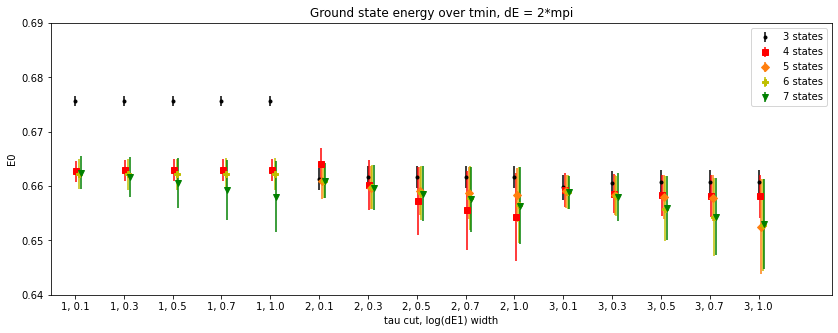

<Figure size 432x288 with 0 Axes>

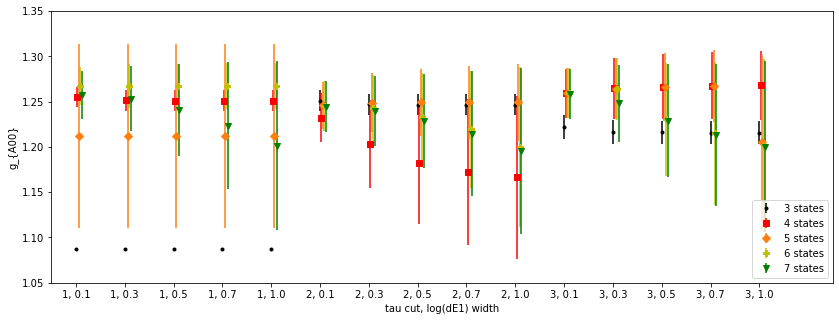

<Figure size 432x288 with 0 Axes>

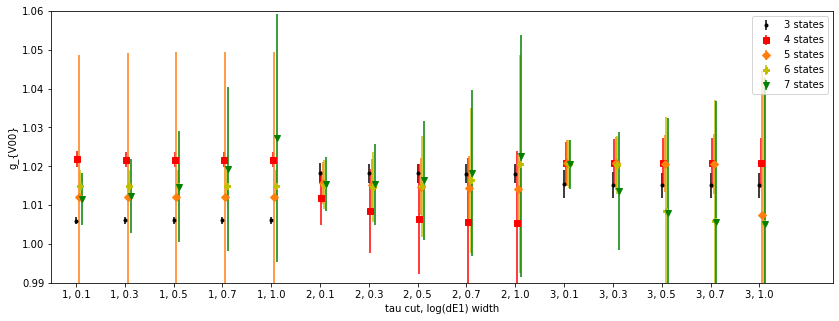

<Figure size 432x288 with 0 Axes>

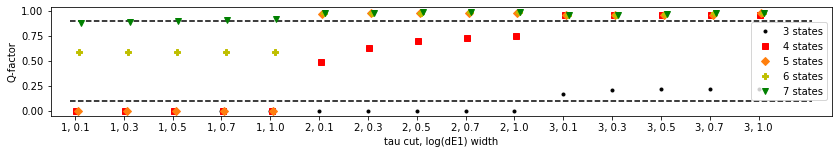

<Figure size 432x288 with 0 Axes>

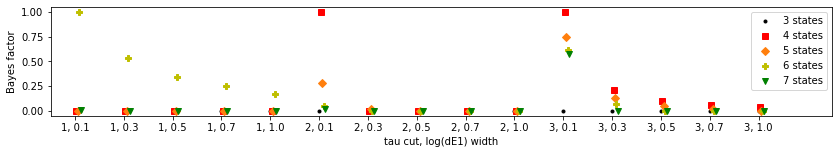

<Figure size 432x288 with 0 Axes>

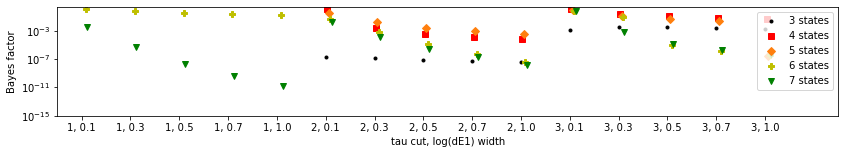

In [51]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.savefig('E0_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

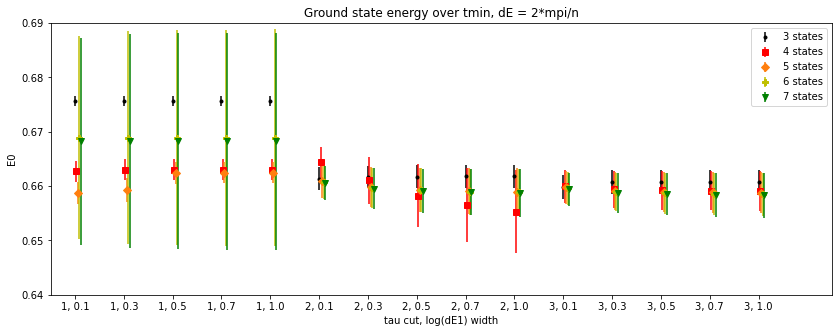

<Figure size 432x288 with 0 Axes>

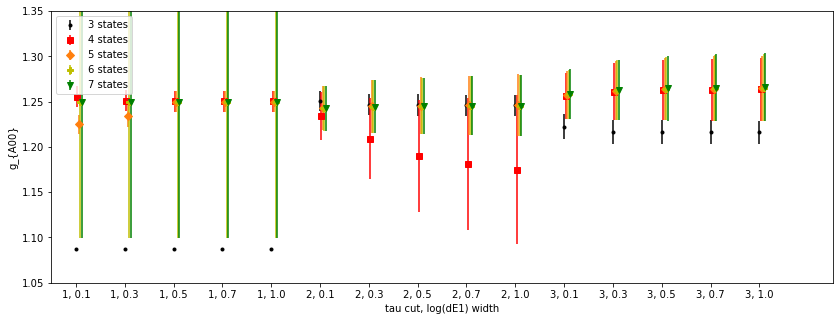

<Figure size 432x288 with 0 Axes>

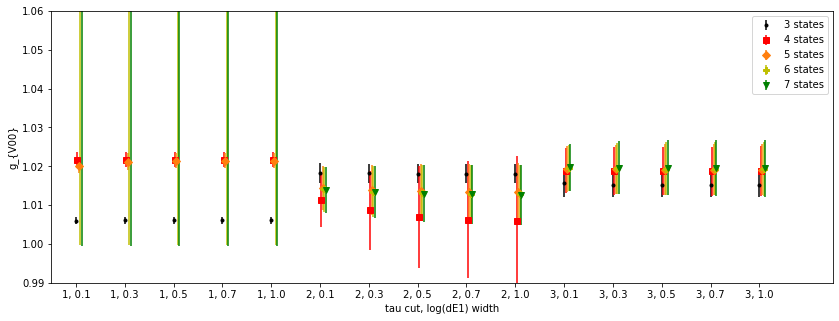

<Figure size 432x288 with 0 Axes>

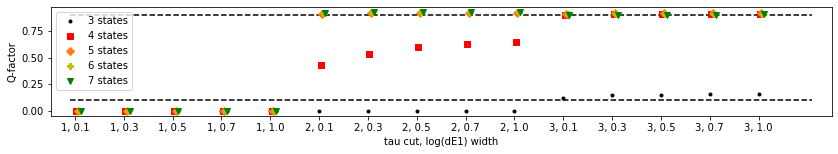

<Figure size 432x288 with 0 Axes>

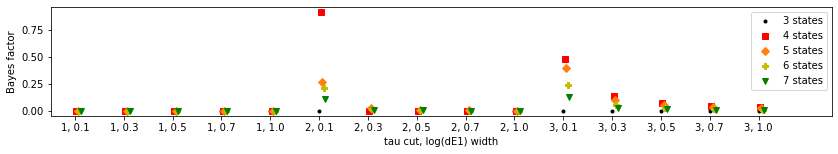

<Figure size 432x288 with 0 Axes>

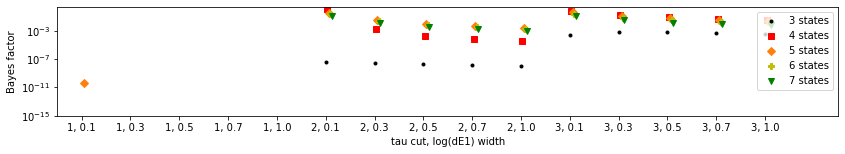

In [52]:
# Now, 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.savefig('E0_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

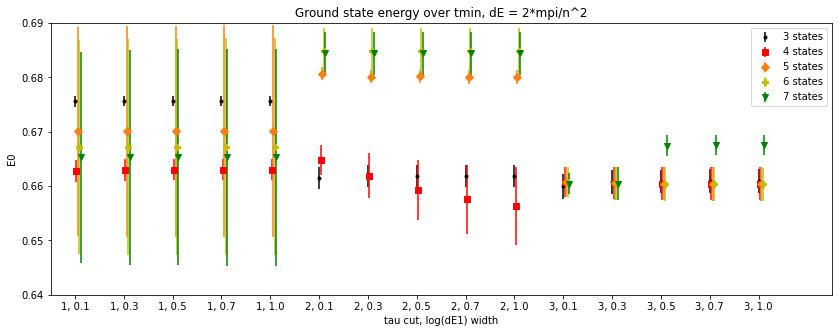

<Figure size 432x288 with 0 Axes>

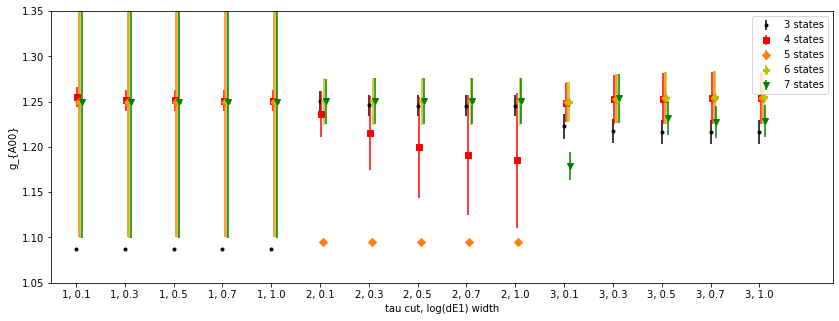

<Figure size 432x288 with 0 Axes>

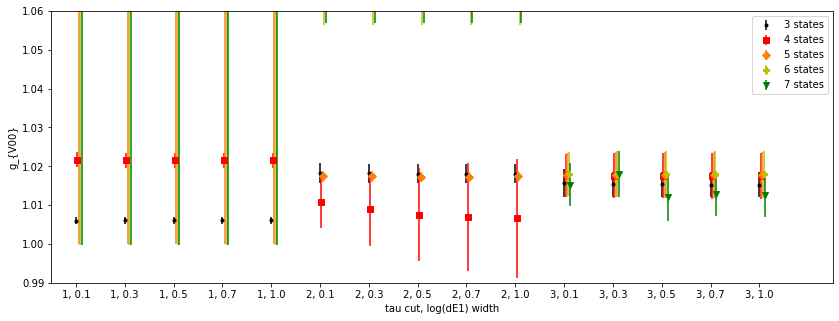

<Figure size 432x288 with 0 Axes>

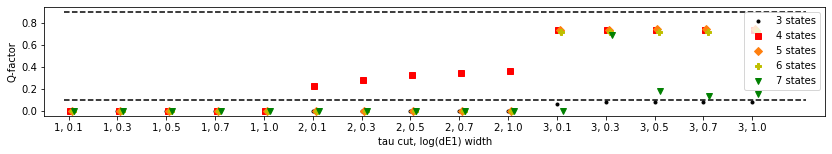

<Figure size 432x288 with 0 Axes>

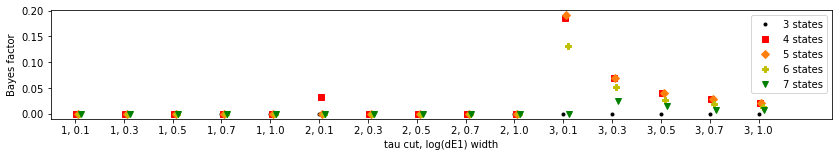

<Figure size 432x288 with 0 Axes>

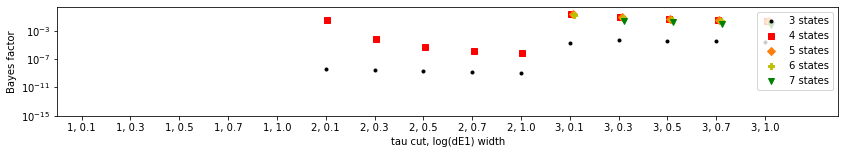

In [53]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.savefig('E0_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()